<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/Overnight_Trading_Strategy_Functions_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
!pip3 install pyfolio
!pip install datetime


OVERNIGHT TRADING STRATEGY

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [212]:

import datetime
import pyfolio as pyf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

day = 4
month = 8
year = 2022
delta = 1

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = True
LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker + ".IS"

TR_Tickers = ["EREGL", "CANTE", "GARAN", "KCHOL", "EUPWR"]
US_Tickers = ["TSLA", "AAPL", "GOOGL", "BA", "V"]
DOW30 = ["AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","JNJ","KO","JPM",
         "MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM","VZ","V","WBA","WMT","DIS","DOW"]

BIST30 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK"]


In [213]:
def UpdateData(TickerIS, START, END):

  # For data manupulations

  # VF    LB    PEAK_CUM  CUM_LAST    REVERSED
  # 0.25  45    6.11       4.29 OK    True
  # 0.35  45    7.42       5.02 OK    True
  # 0.40  45    7.64       5.17 OK    True
  # 0.45  45    8.99       6.16 OK    True
  # 0.45  45    1.22       1.05 OK    False
  # 0.45  55    7.97       5.39 OK    True
  # 0.45  40    9.35       6.31 OK    True
  # 0.45  35    9.65       7.14 OK    True
  # 0.45  33    9.78       7.24 OK    True  ***
  # 0.45  32    10.02      7.42 OK    True  ****
  # 0.45  30    9.16       6.78 OK    True
  # 0.45  25    8.19       5.98 OK    True
  # -   -       5.17       4.82 OK    True / original Gap up buy side.

  # Read data from Yahoo finance

  data = yf.download(TickerIS,START, END)
  # Convert index into datetime format
  data.index = pd.to_datetime(data.index,format="%d-%m-%Y")
  # Calculate adjustment factor
  adjusted_factor = data['Adj Close'] / data['Close']
  # Calculate adjusted open price
  data['Adj Open'] = adjusted_factor * data['Open']
  data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

  data['std'] = data['returns'].rolling(R_WINDOW).std()
  data['positions'] = np.nan
  data['close']= data['Adj Close']
  data["log_returns"] = data['close'].pct_change().apply(lambda x: np.log(1+x))
  data["rel"]= data['Adj Close'] / data['Adj Close'][0]

  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true

  data.loc[long_entry, 'positions'] = 1
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  data['cumulative_normal_returns'] = (data.returns+1).cumprod()
  data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()

  return data

In [214]:
# Calculate returns


In [215]:
# Calculate standard deviation of returns


In [216]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [217]:
# IMPROVED STRATEGY
def Strategy(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  # data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  return data



In [218]:


# Drop NaN values
#data = data.dropna()

In [219]:
def CalculateStrReturns(data):
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  return data

In [220]:
def PlotRelative(data):
  global  LEFT, RIGHT, R_WINDOW
  plt.subplot(4, 1, 1)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close'])
  plt.title(f"{Ticker} time series")

  plt.subplot(4, 1, 2)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['rel'])
  plt.title(f"{Ticker} relative time series")



  plt.subplot(4, 1, 3)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['log_returns'])
  plt.title(f"{Ticker} returns time series")

  plt.subplot(4, 1, 4)
  plt.xlim(LEFT, RIGHT)
  data_vlt = data['close'].rolling(R_WINDOW).std()*(252**0.5)

  plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  plt.plot(data['std']*252**0.5)

  fig = plt.gcf()
  fig.set_size_inches(16, 16)
  plt.show()

In [221]:
def PlotFunction(Ticker,data):
  # Plot cumulative returns

  import datetime

  plt.figure(figsize=(14,11))

  plt.subplot(4, 1, 1)
  global LEFT, RIGHT
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close'])
  plt.title(f"{Ticker} time series", fontsize=16)
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Price', fontsize=14)
  plt.grid()

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 2)
  plt.xlim(LEFT, RIGHT)


  plt.plot(data.cumulative_normal_returns)
  plt.title(f"{Ticker} normal returns")
  plt.grid()
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Cumulative strategy returns
  # Define the label for the title of the figure
  plt.title(f"{Ticker} Cumulative Returns", fontsize=16)
  # Define the labels for x-axis and y-axis
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Overnight Returns', fontsize=14)

  # Define the tick size for x-axis and y-axis
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 3)
  plt.xlim(LEFT, RIGHT)



  plt.plot(data.cumulative_strategy_returns)
  plt.title(f"{Ticker} returns time series")
  plt.grid()
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Cumulative strategy returns
  # Define the label for the title of the figure
  plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
  # Define the labels for x-axis and y-axis
  plt.xlabel('Date', fontsize=14)
  plt.ylabel('Cumulative Returns', fontsize=14)

  # Define the tick size for x-axis and y-axis
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 4)
  plt.xlim(LEFT, RIGHT)
  plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  plt.xlabel('Date', fontsize=14)
  plt.ylabel(f'{Ticker} volatility', fontsize=14)
  plt.grid()
  plt.xticks(fontsize=12)

  plt.plot(data['std']*252**0.5)
  fig = plt.gcf()
  fig.set_size_inches(16, 22)
  plt.show()

In [222]:
def ShowDataTable(data):
  global year, day, month
  return(data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna())




In [223]:
def CreateTearSheetForData(data):
  pyf.create_simple_tear_sheet(data.returns.dropna())

In [224]:
def EvaluateFeasibility(data):
  Max_Cum_Norm_Ret = np.max(data.cumulative_normal_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return feasible

In [225]:
def EvaluateFeasibility_v2(data):
  Max_Cum_Norm_Ret = np.max(data.cumulative_normal_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible

In [226]:
def ShowTRMarket(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:
    ticker = ticker + ".IS"
    d = UpdateData(ticker, START, END)
    d = Strategy(d)
    opc,clo,fb = EvaluateFeasibility_v2(d)
    if fb>1.2 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df



In [227]:
def ShowUSMarket(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:

    d = UpdateData(ticker, START, END)
    d = Strategy(d)
    opc,clo,fb = EvaluateFeasibility_v2(d)
    if fb>1.2 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [229]:
# def ShowOvernightWinners(Tickers,exchange):

#   my_dict = {"Ticker":[], "MaxReturn":[], "LatestReturn":[], "FB":[]};

#   for ticker in Tickers:
#     if exchange=="BIST":
#       ticker = ticker + ".IS"
#     d = UpdateData(ticker, START, END)
#     d = Strategy(d)

#     fb = EvaluateFeasibility(d)
#     if fb > 1.2 :
#       my_dict["Ticker"].append(ticker)
#       my_dict["FB"].append(fb)
#       # my_dict["MaxReturn"].append(mcnr)
#       # my_dict["LatestReturn"].append(lcnr)

#   df = pd.DataFrame(my_dict)
#   df.sort_values(by=['FB'], ascending=False, inplace=True)
#   print(df)
#   return df



In [232]:
def ShowTickerStats(ticker, exchange):
  d = UpdateData(ticker, START, END)
  d = Strategy(d)
  PlotFunction(ticker, d)
  CreateTearSheetForData(d)
  return d

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

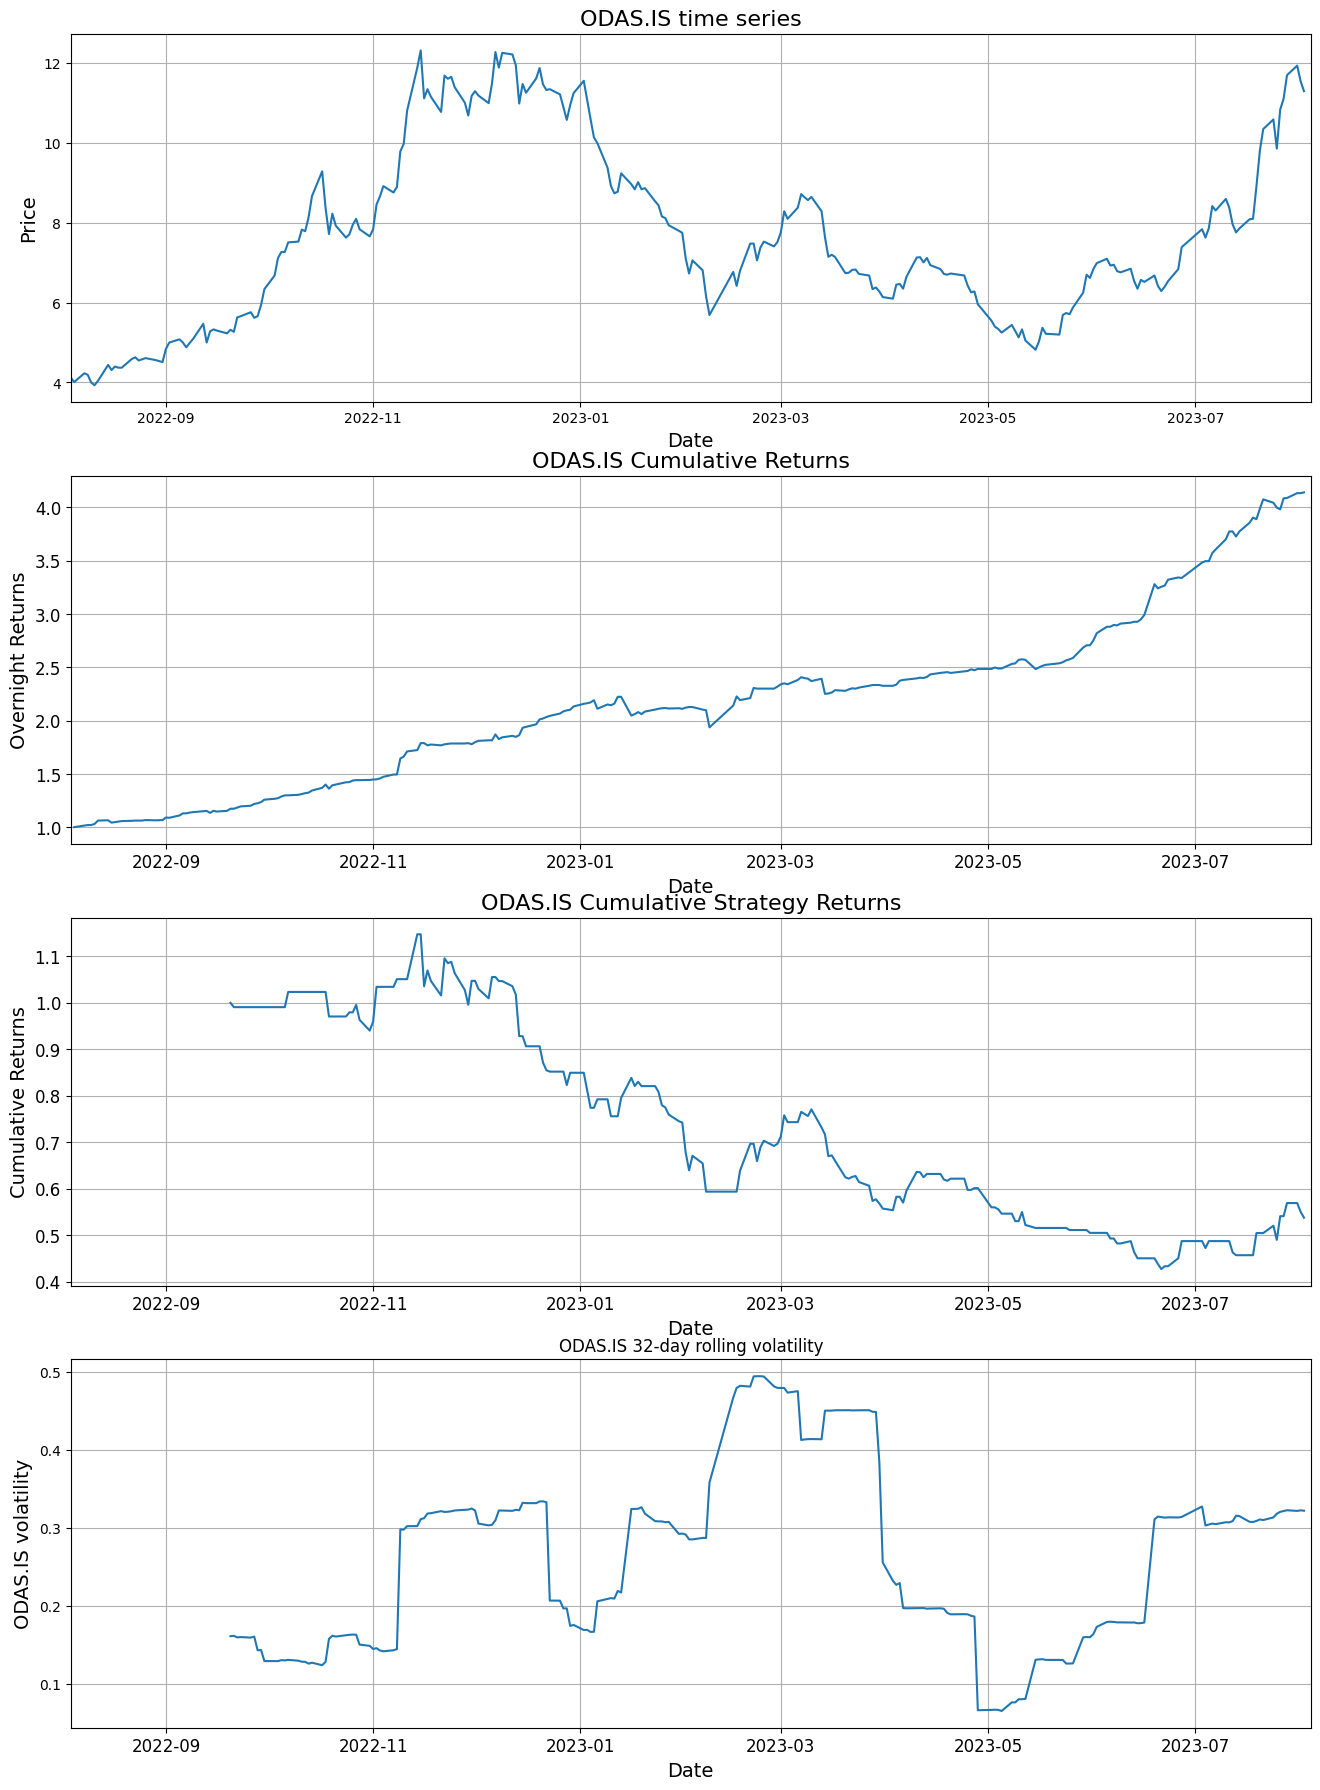

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


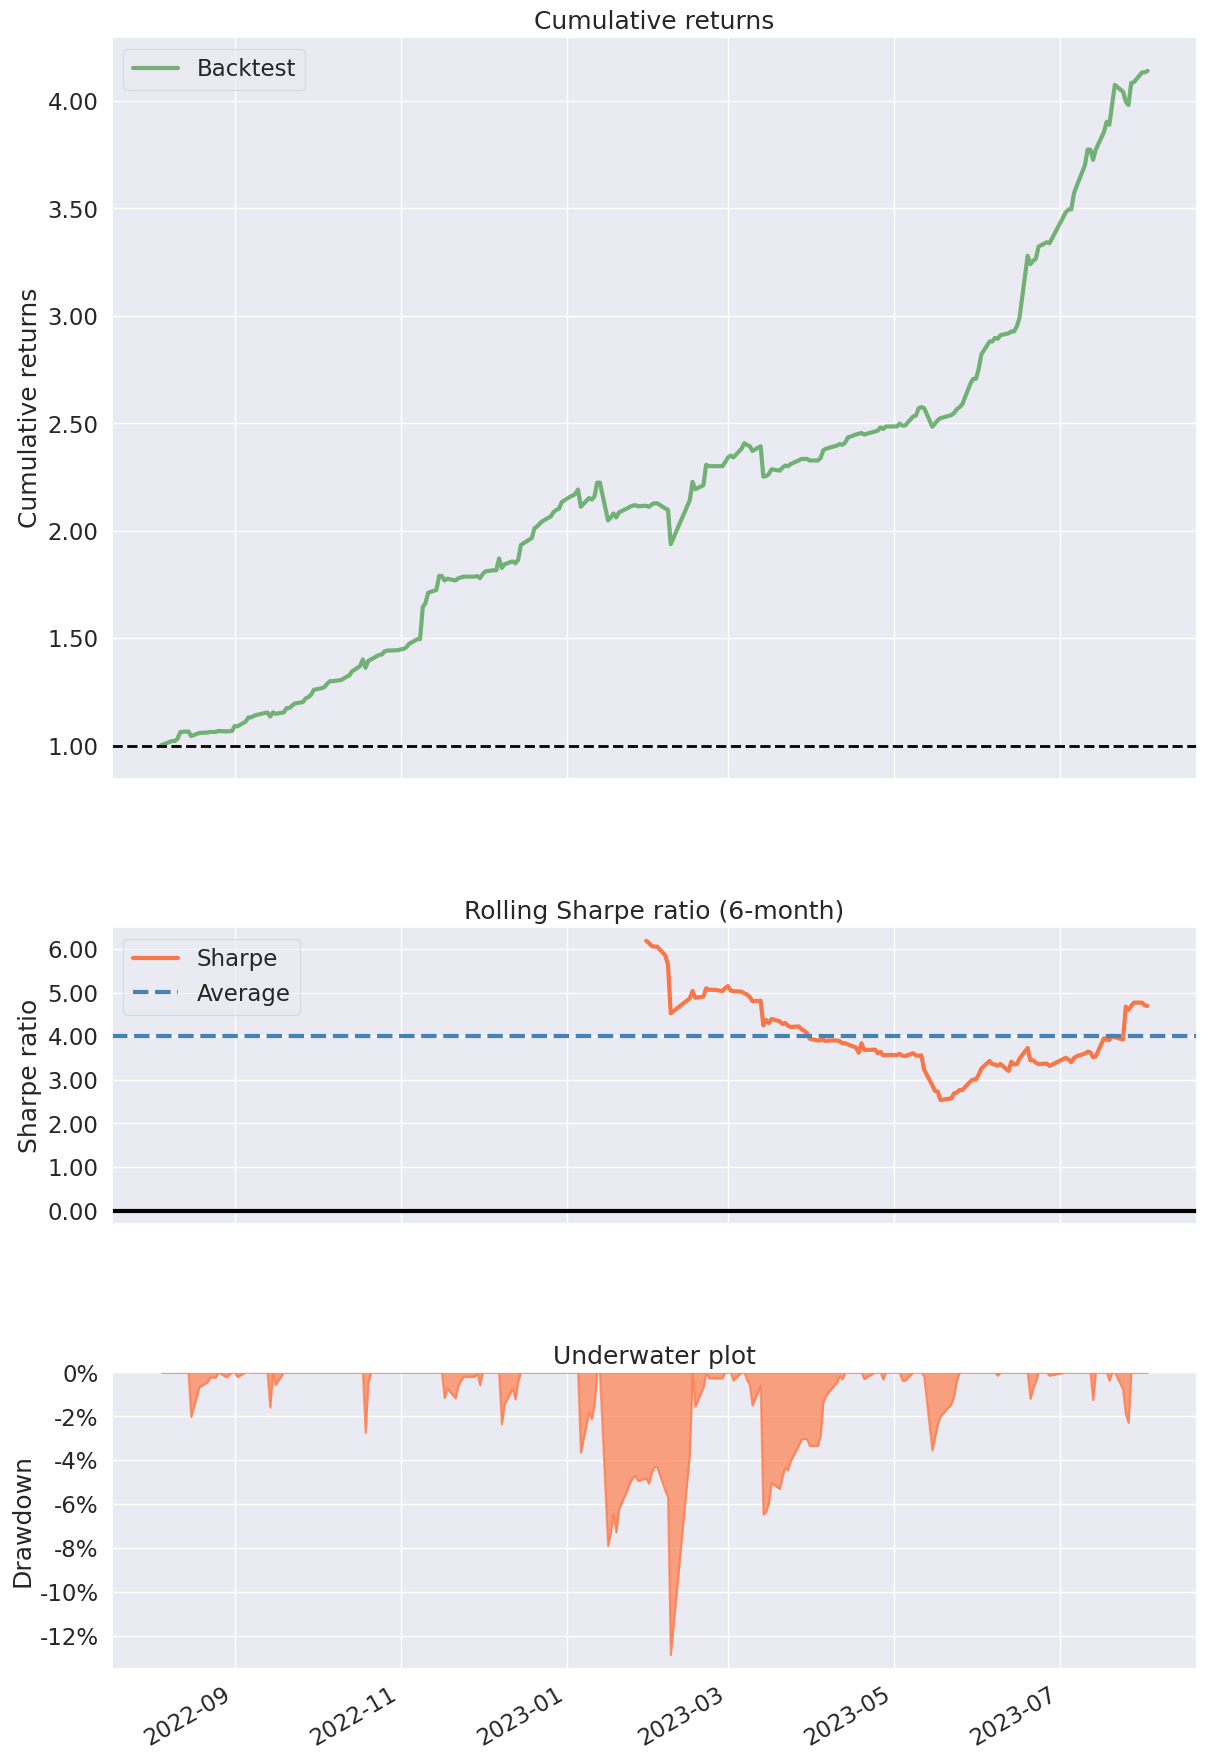

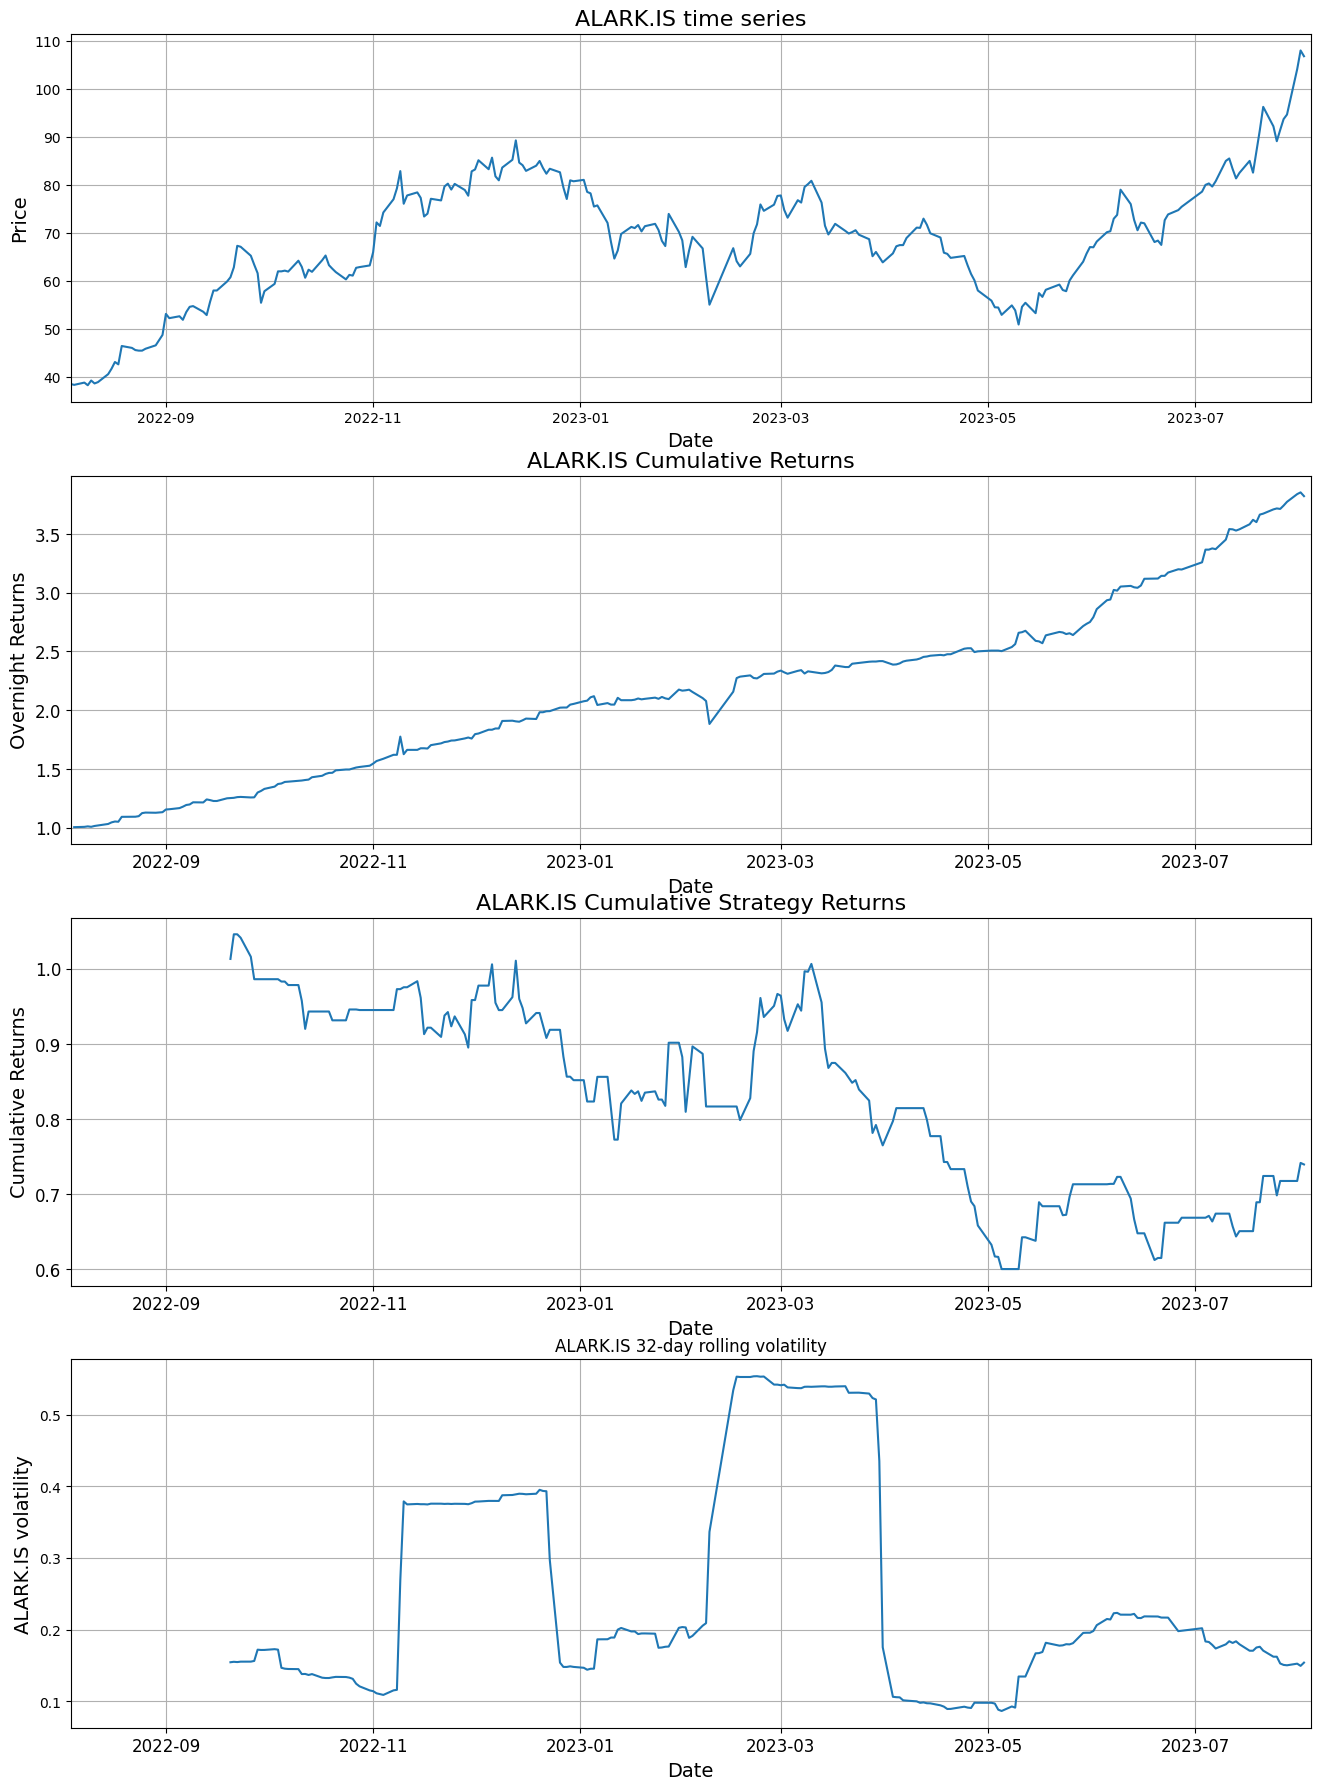

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


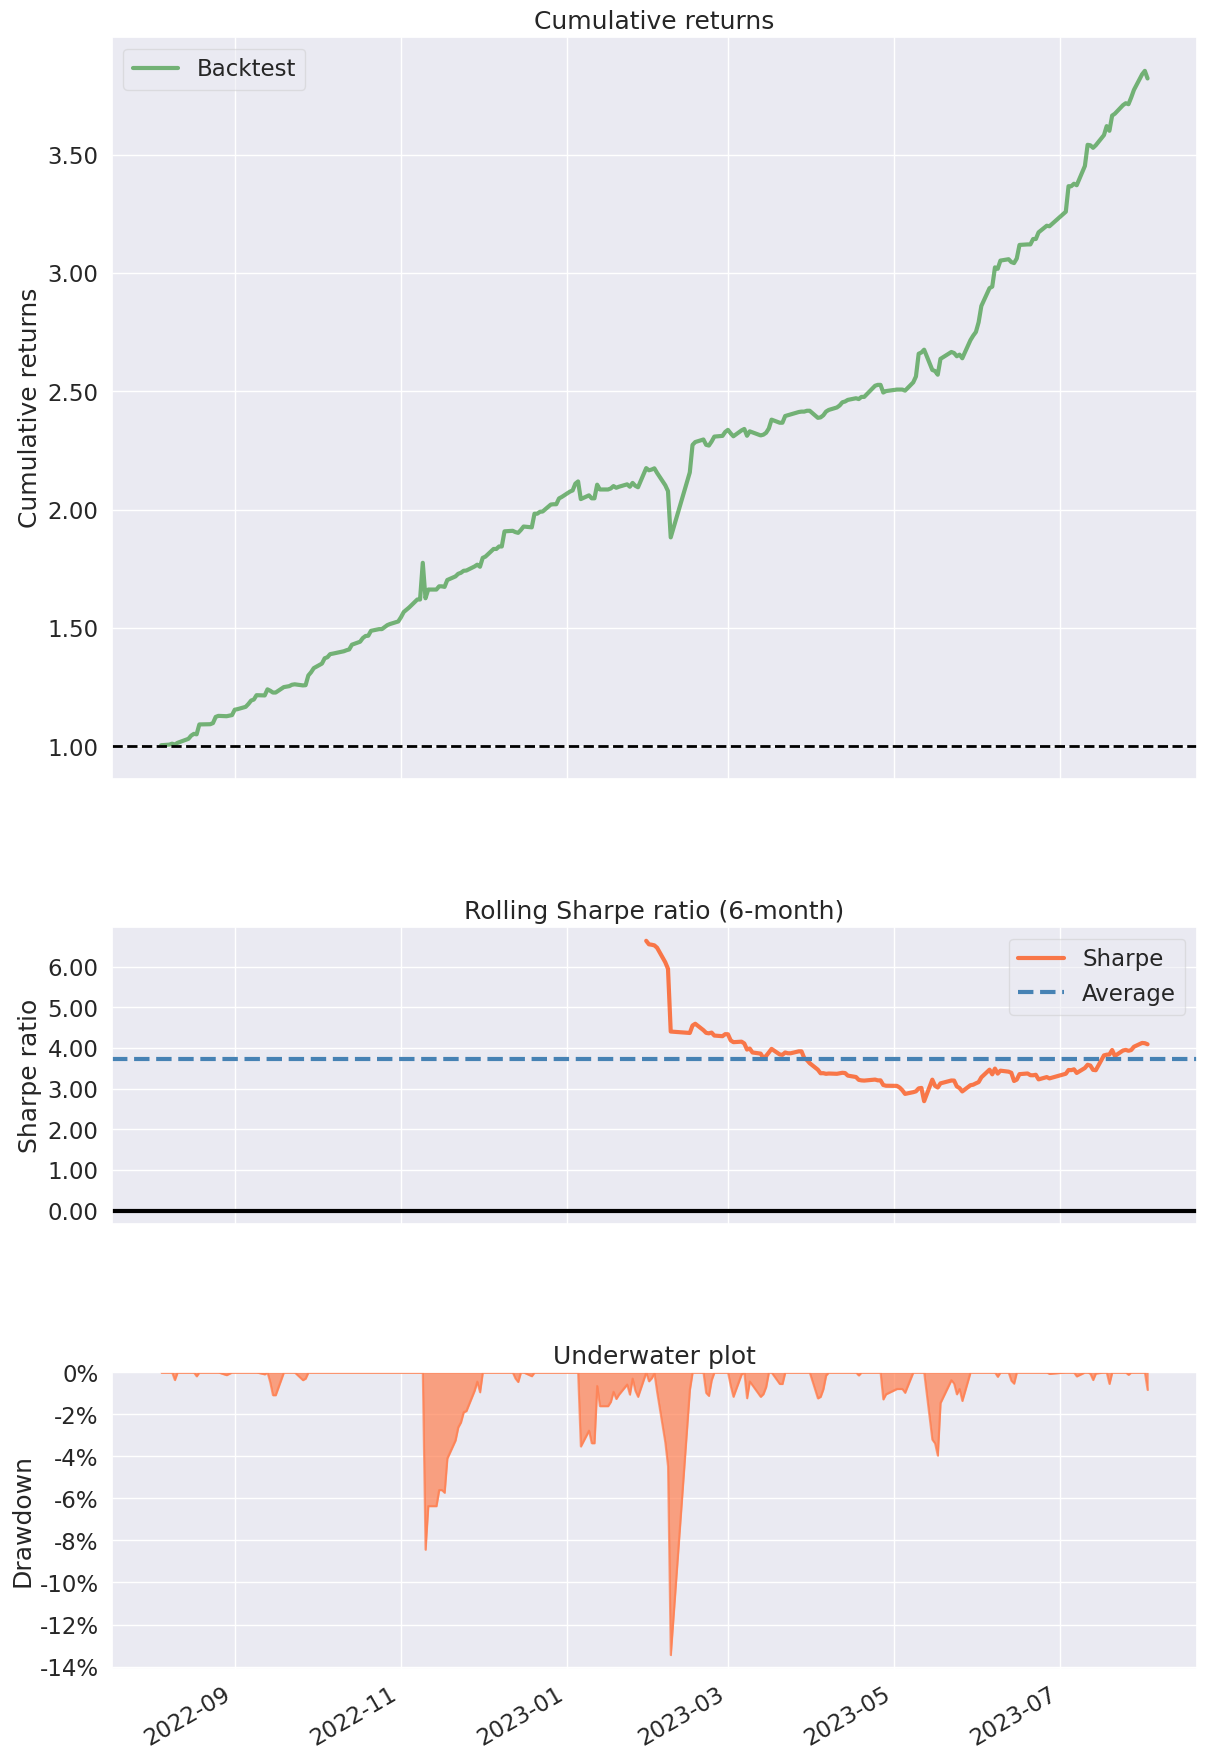

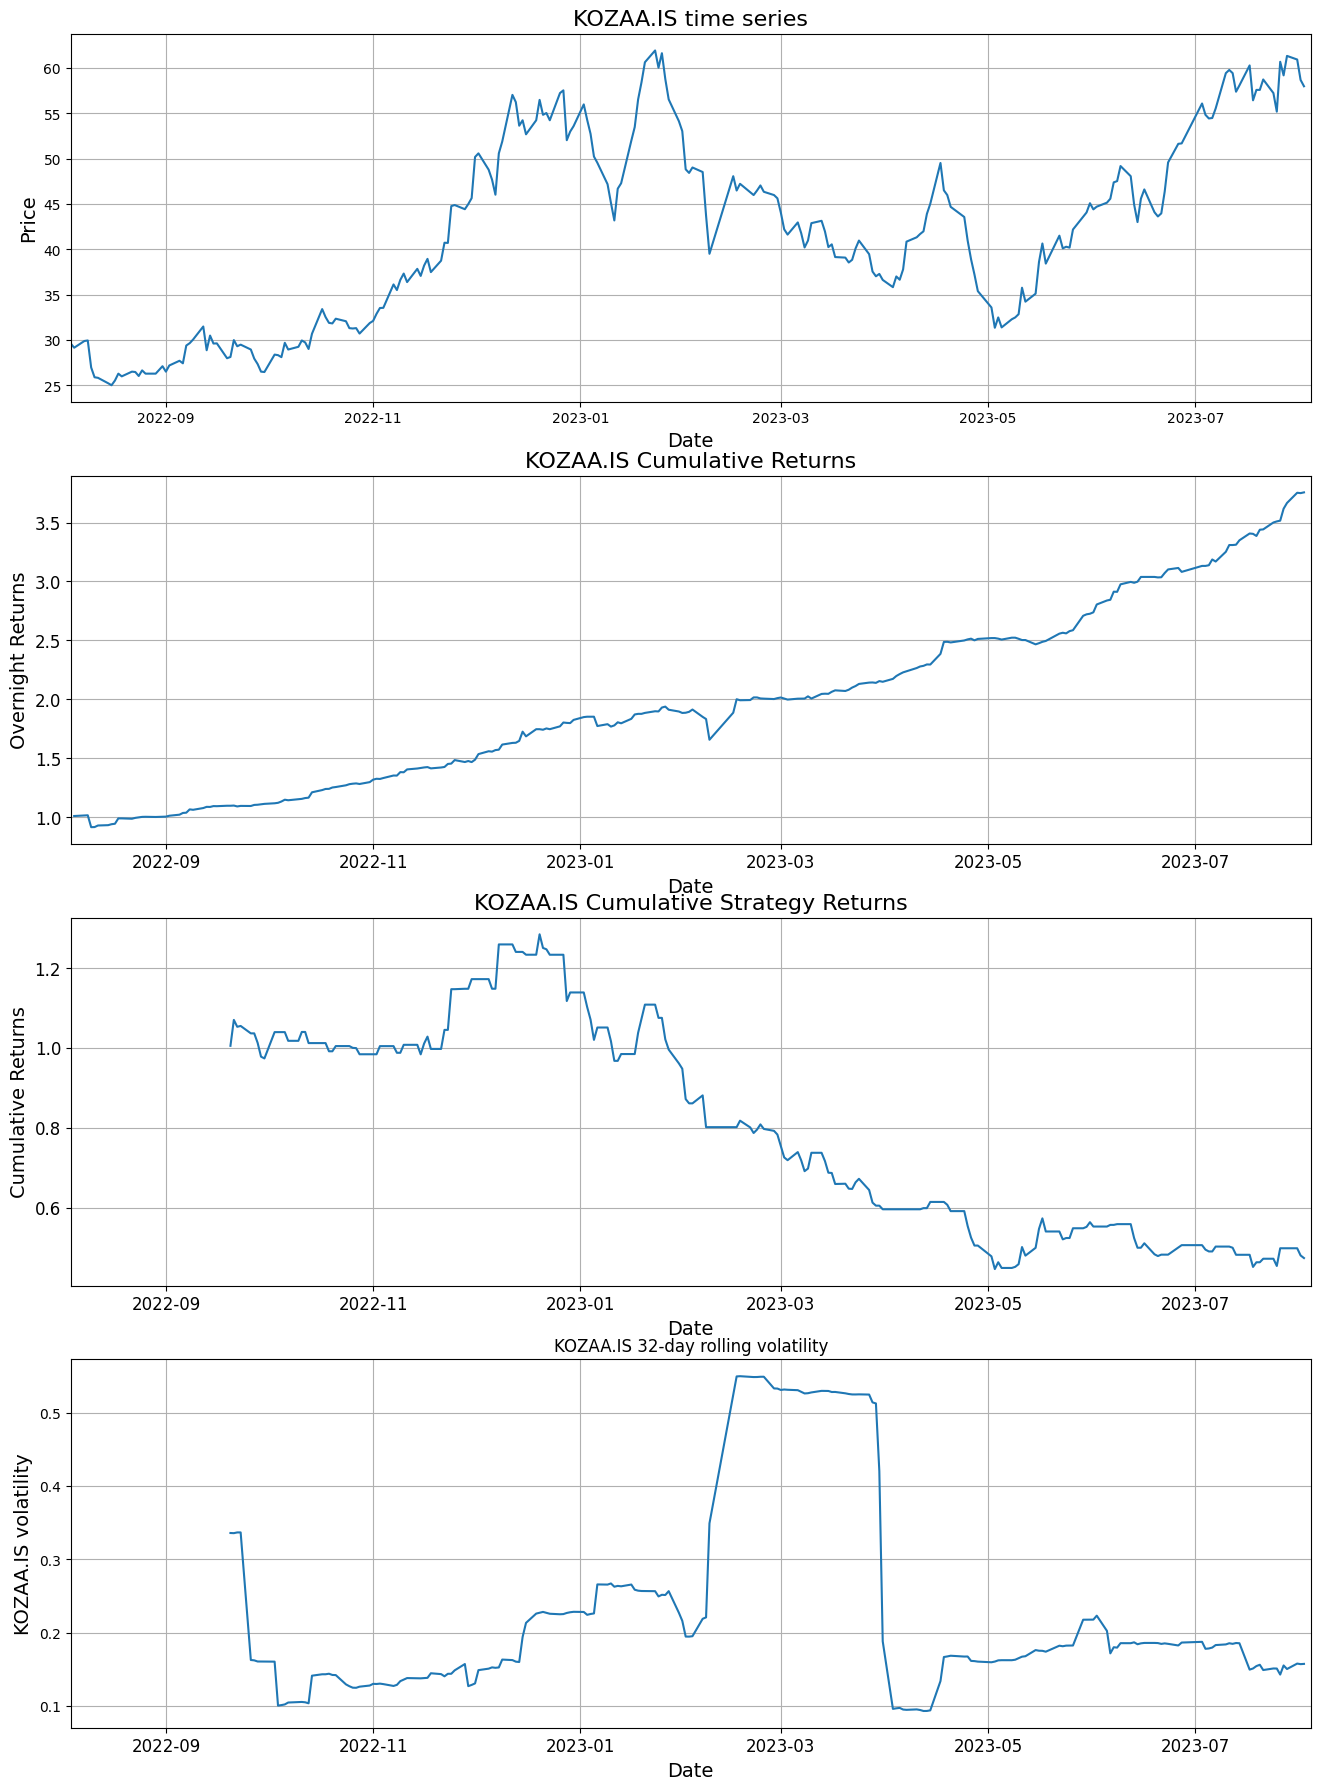

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


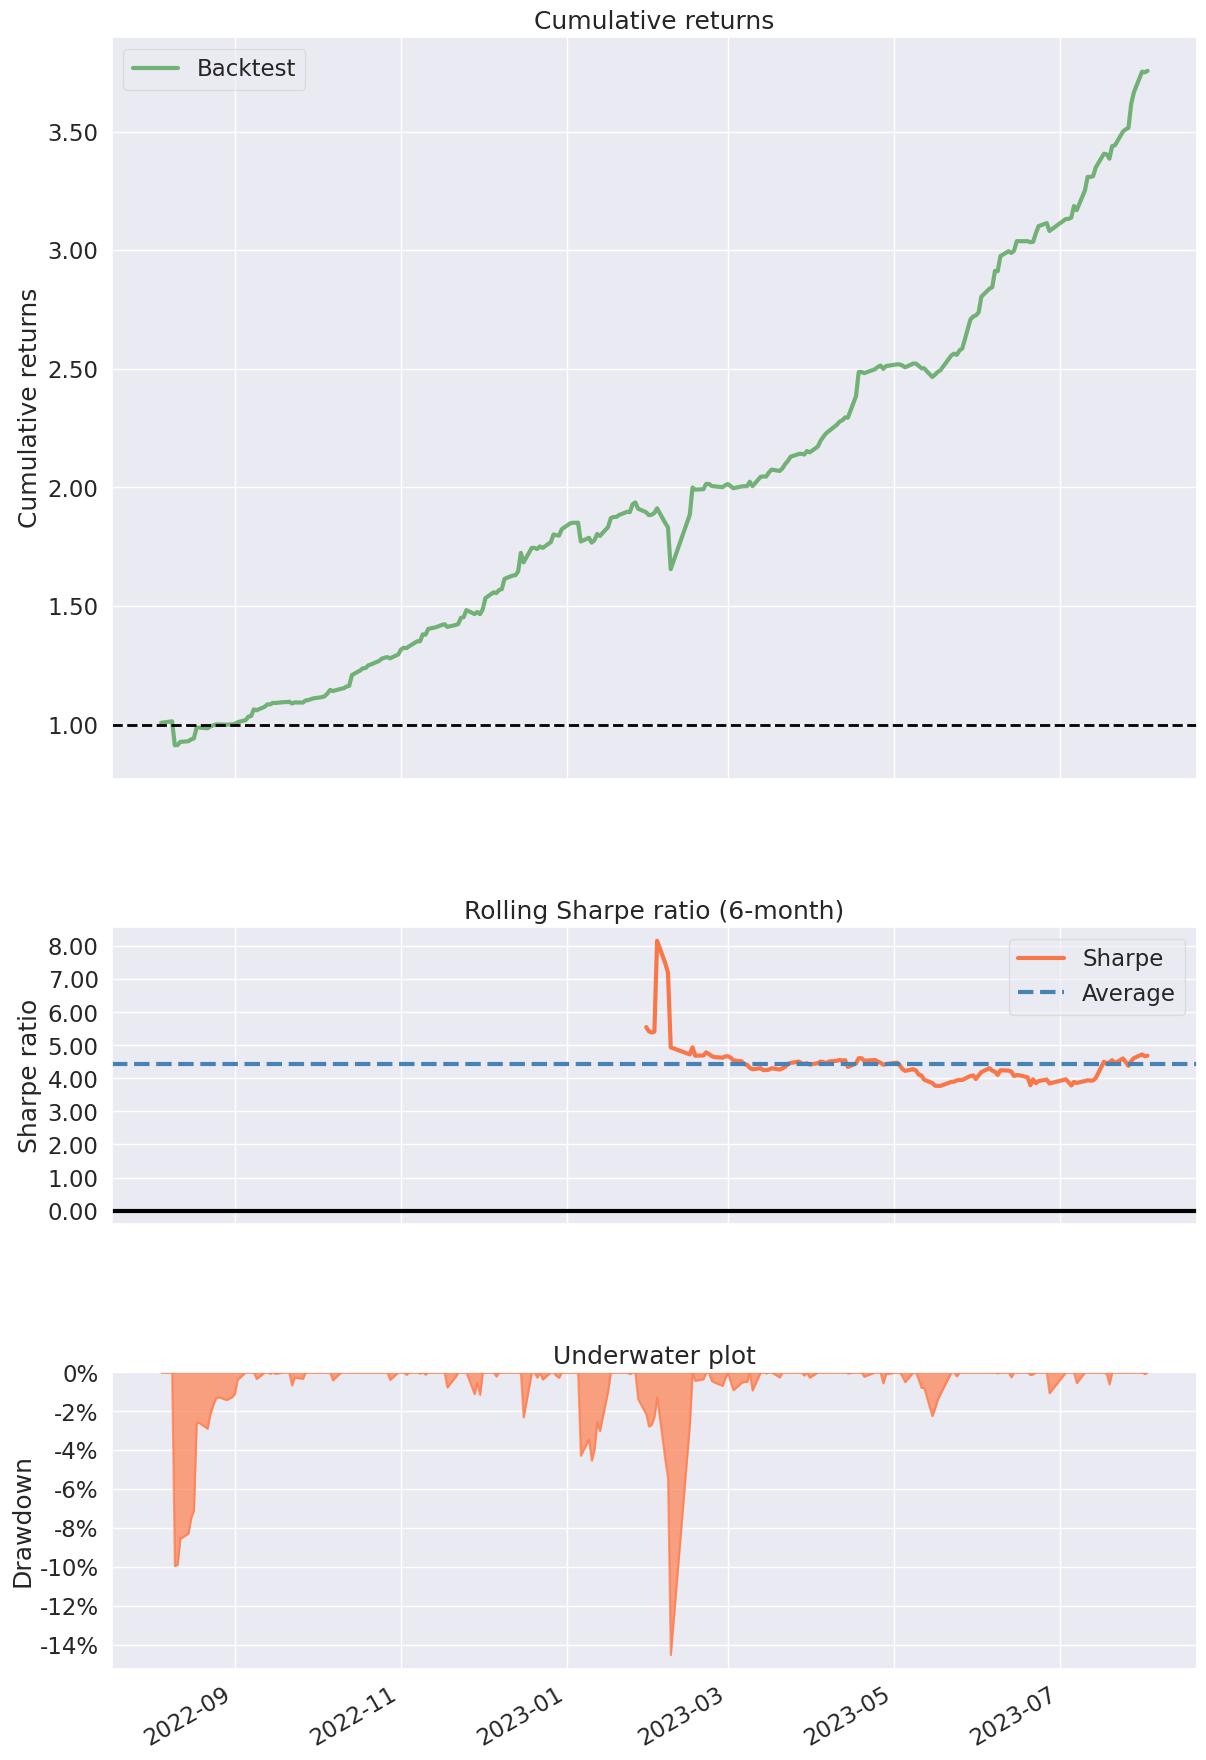

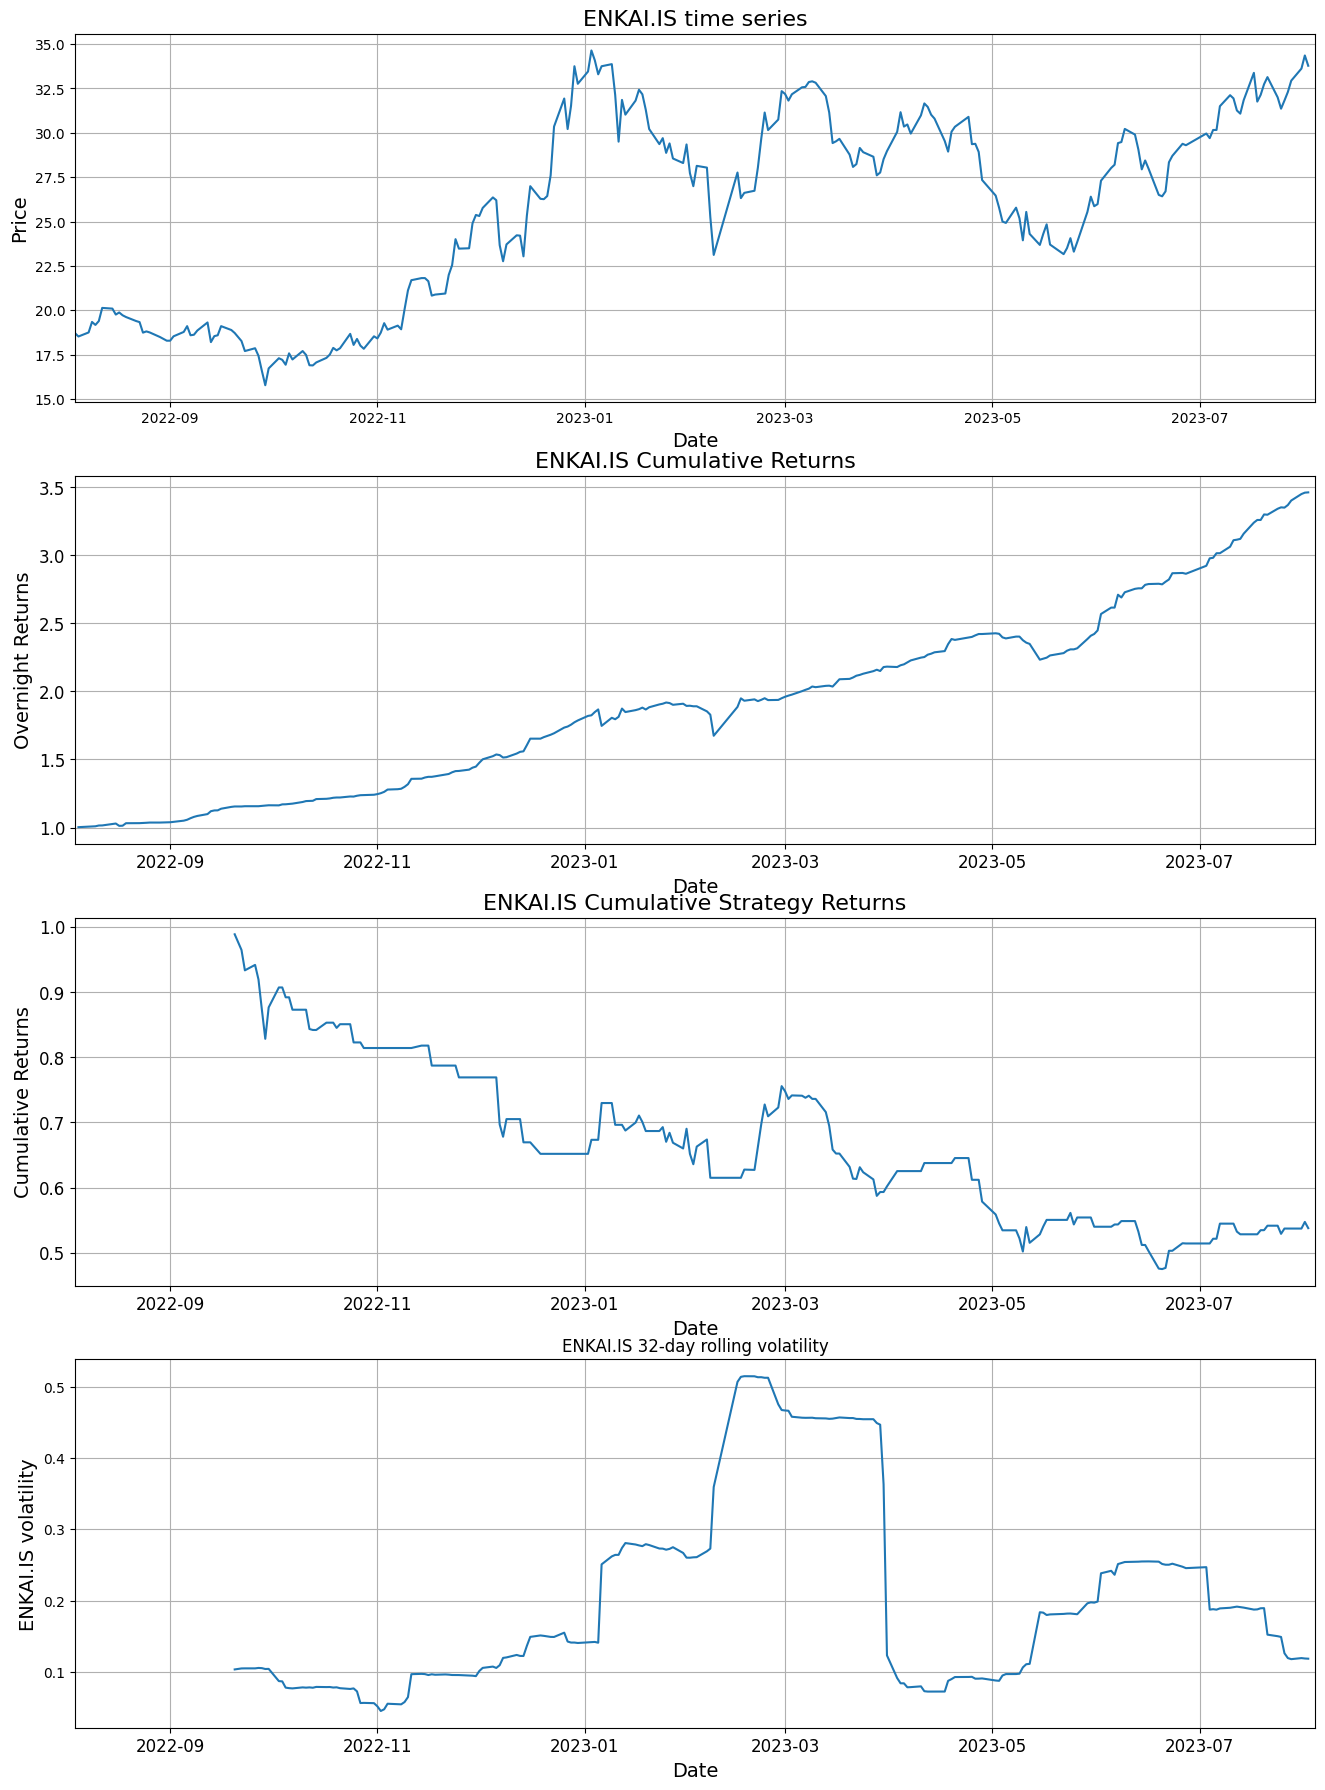

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


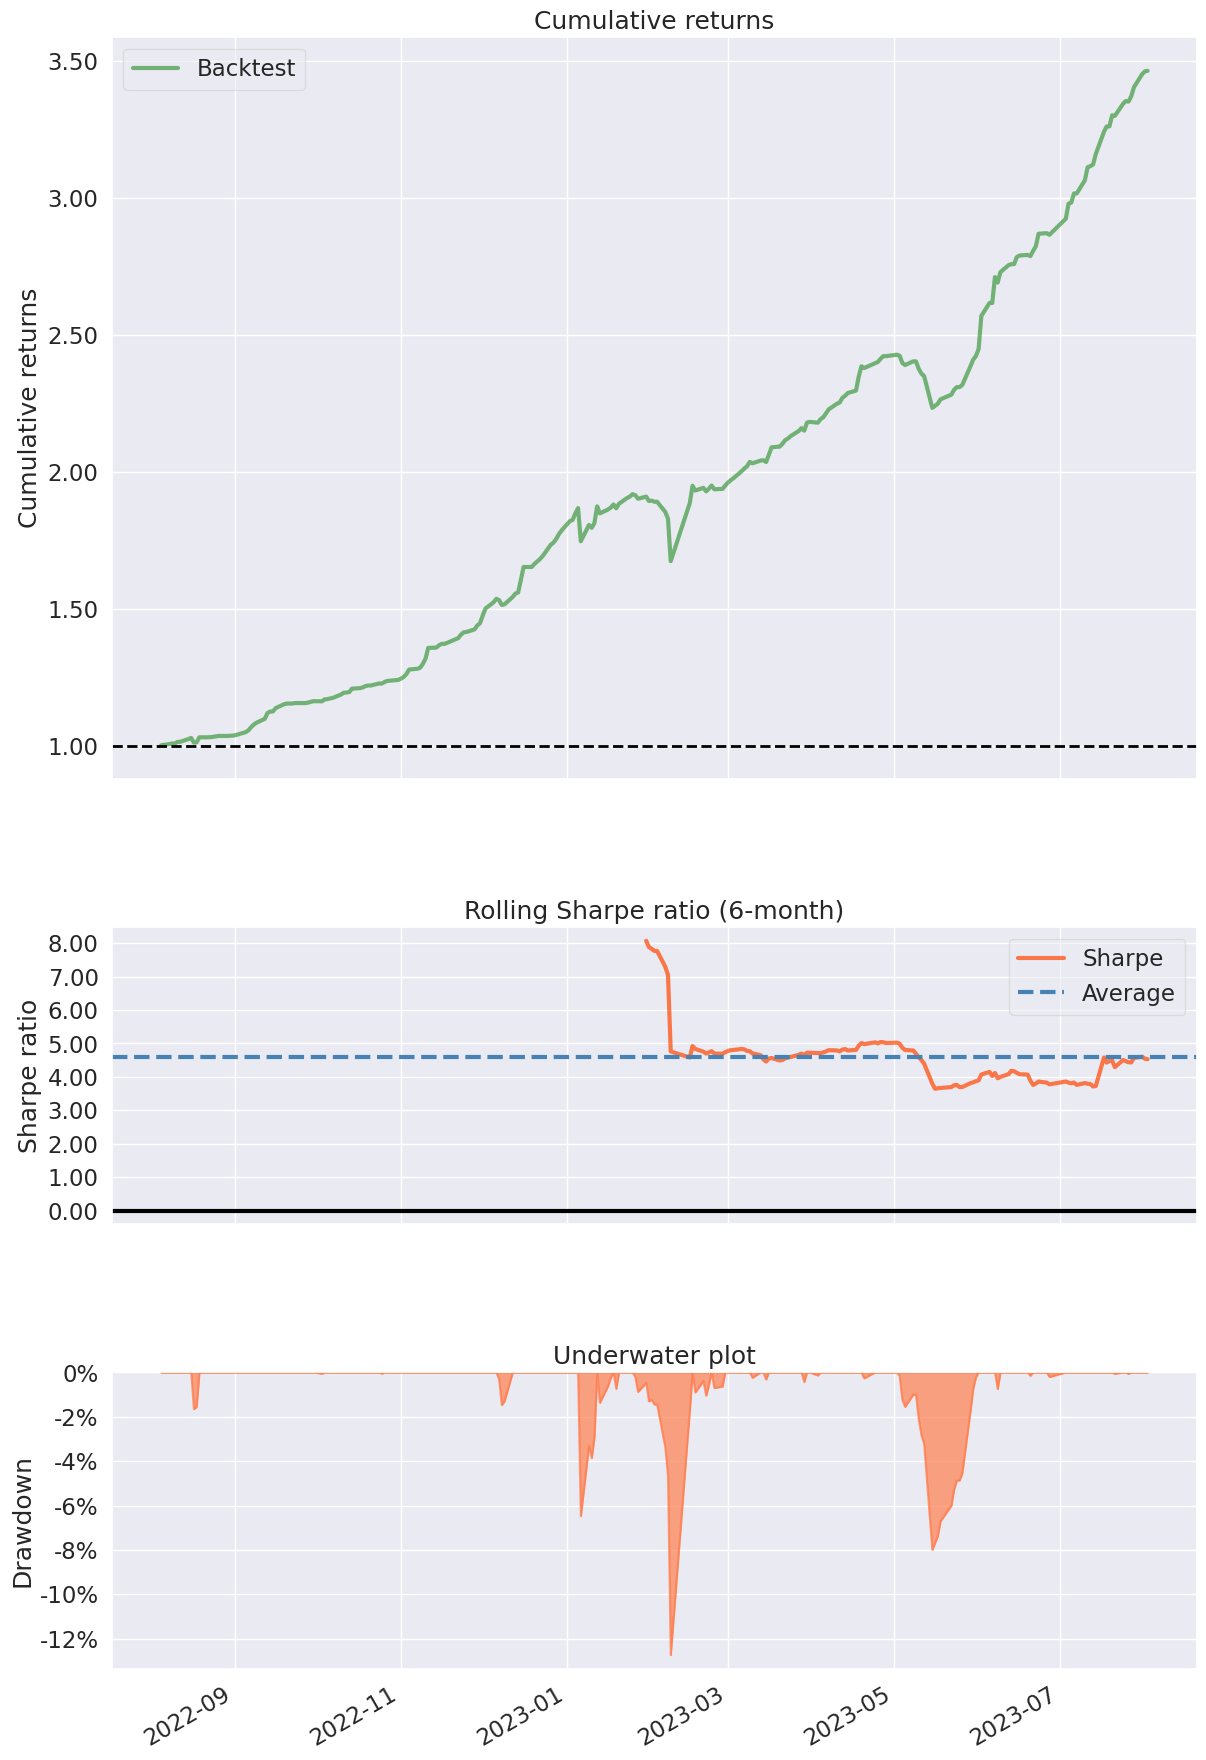

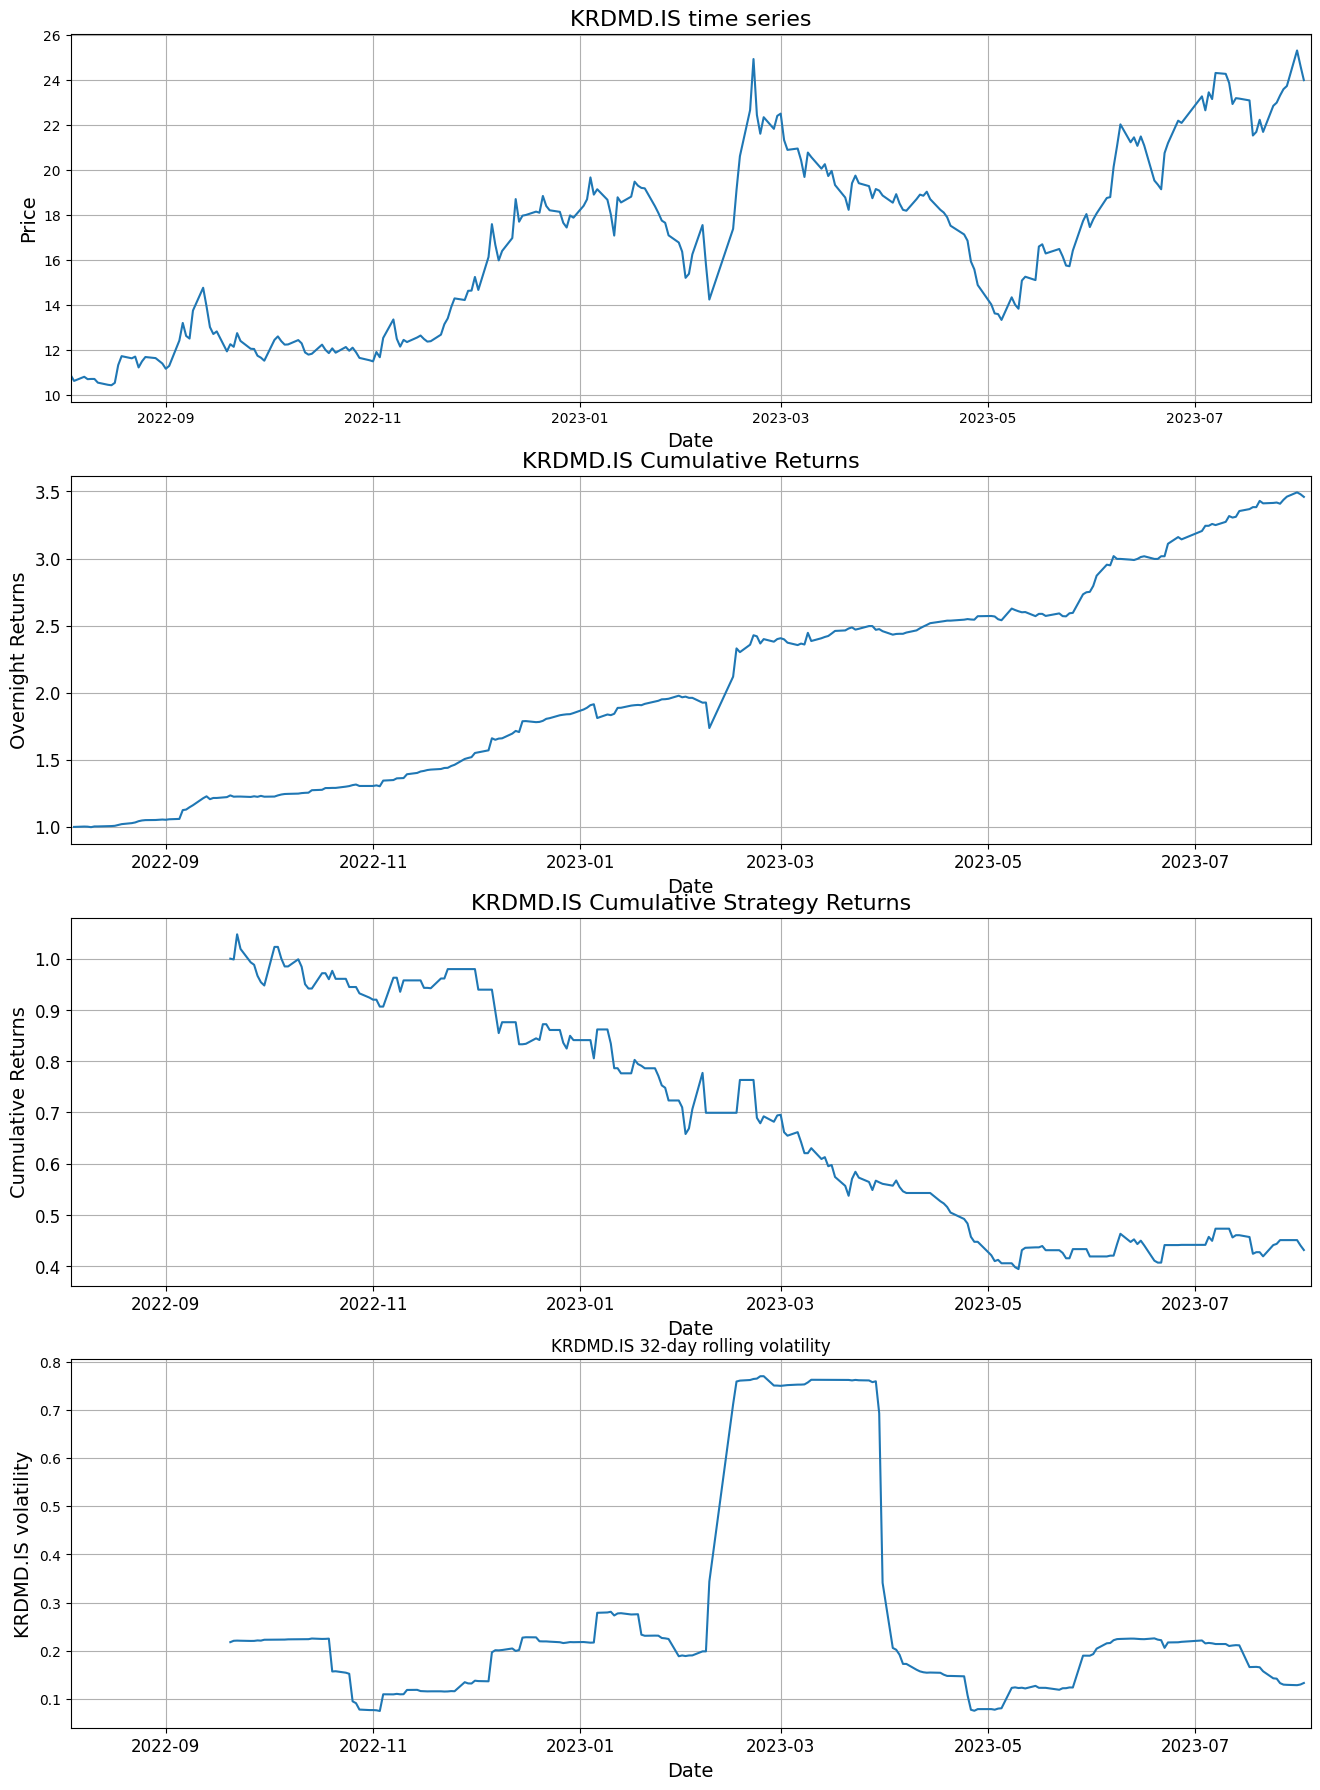

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


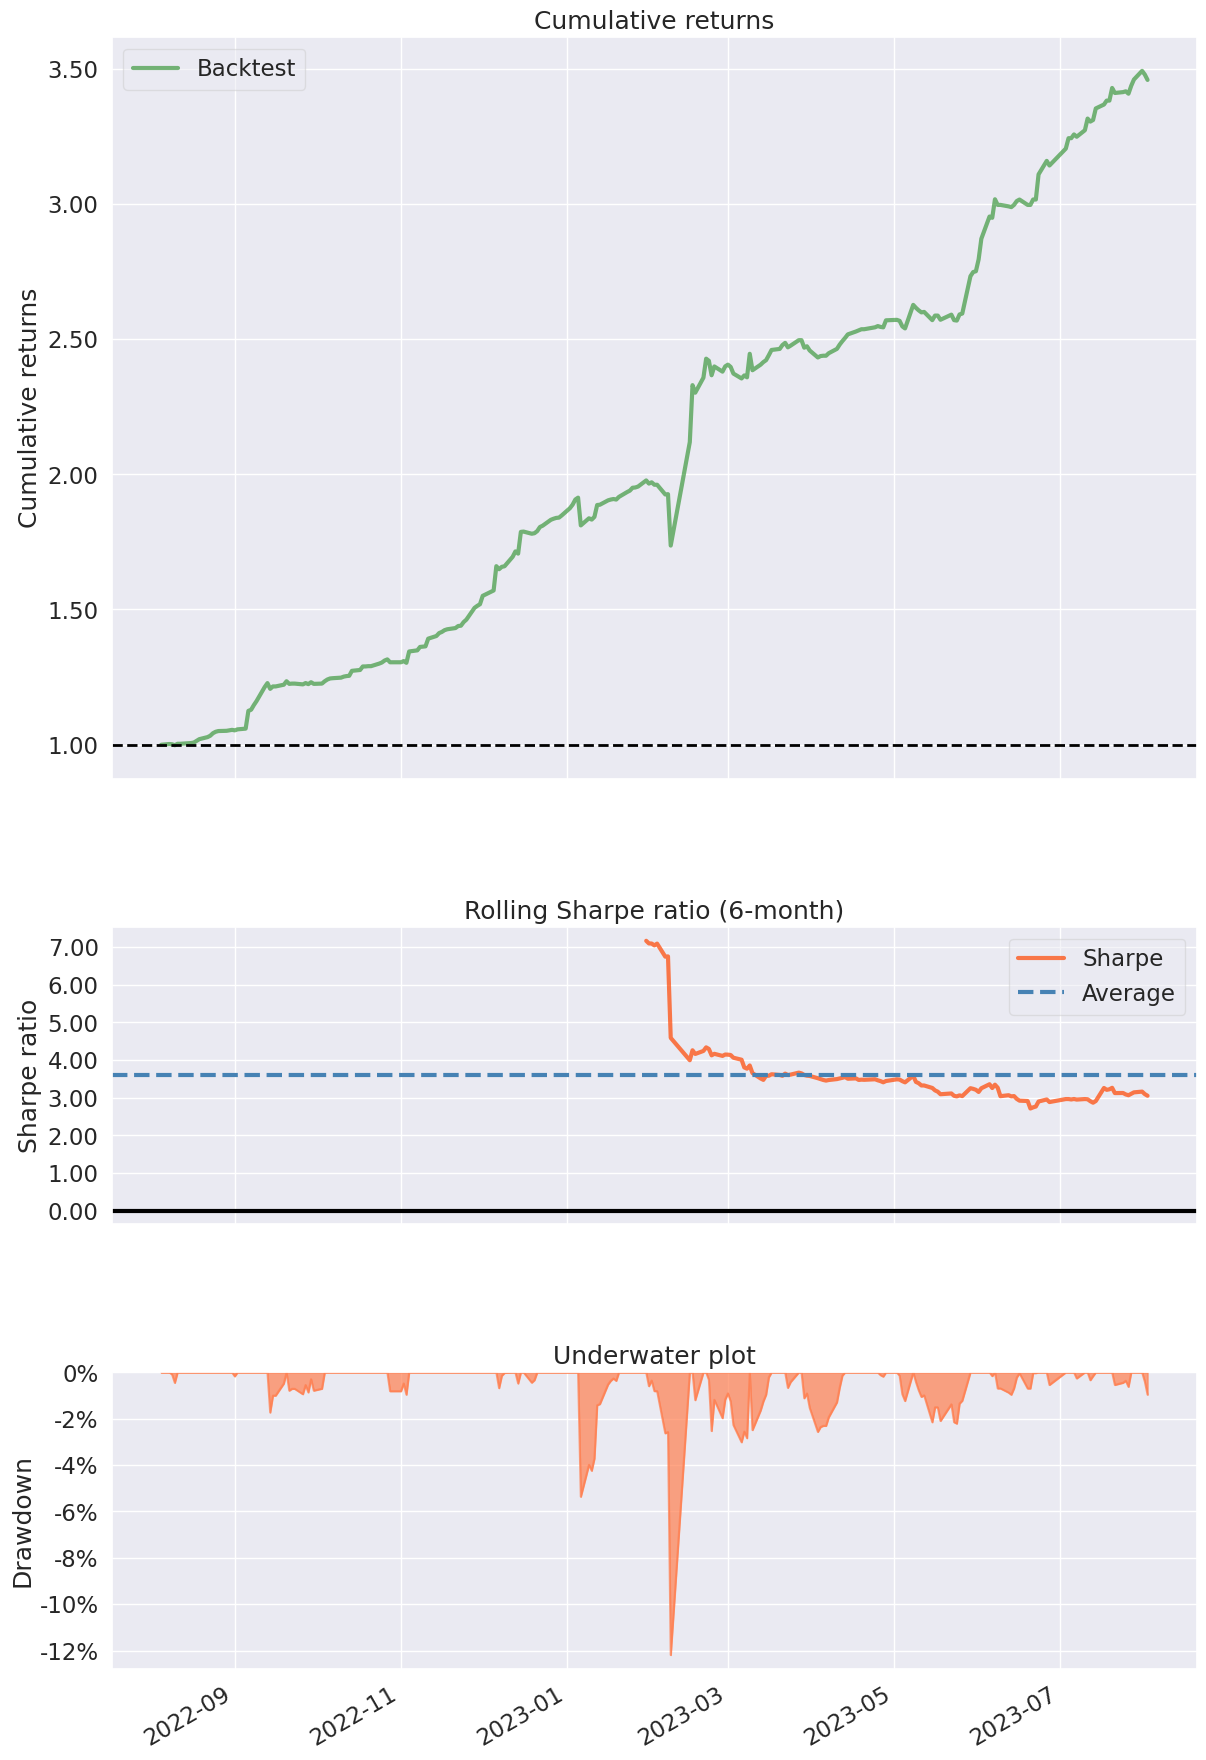

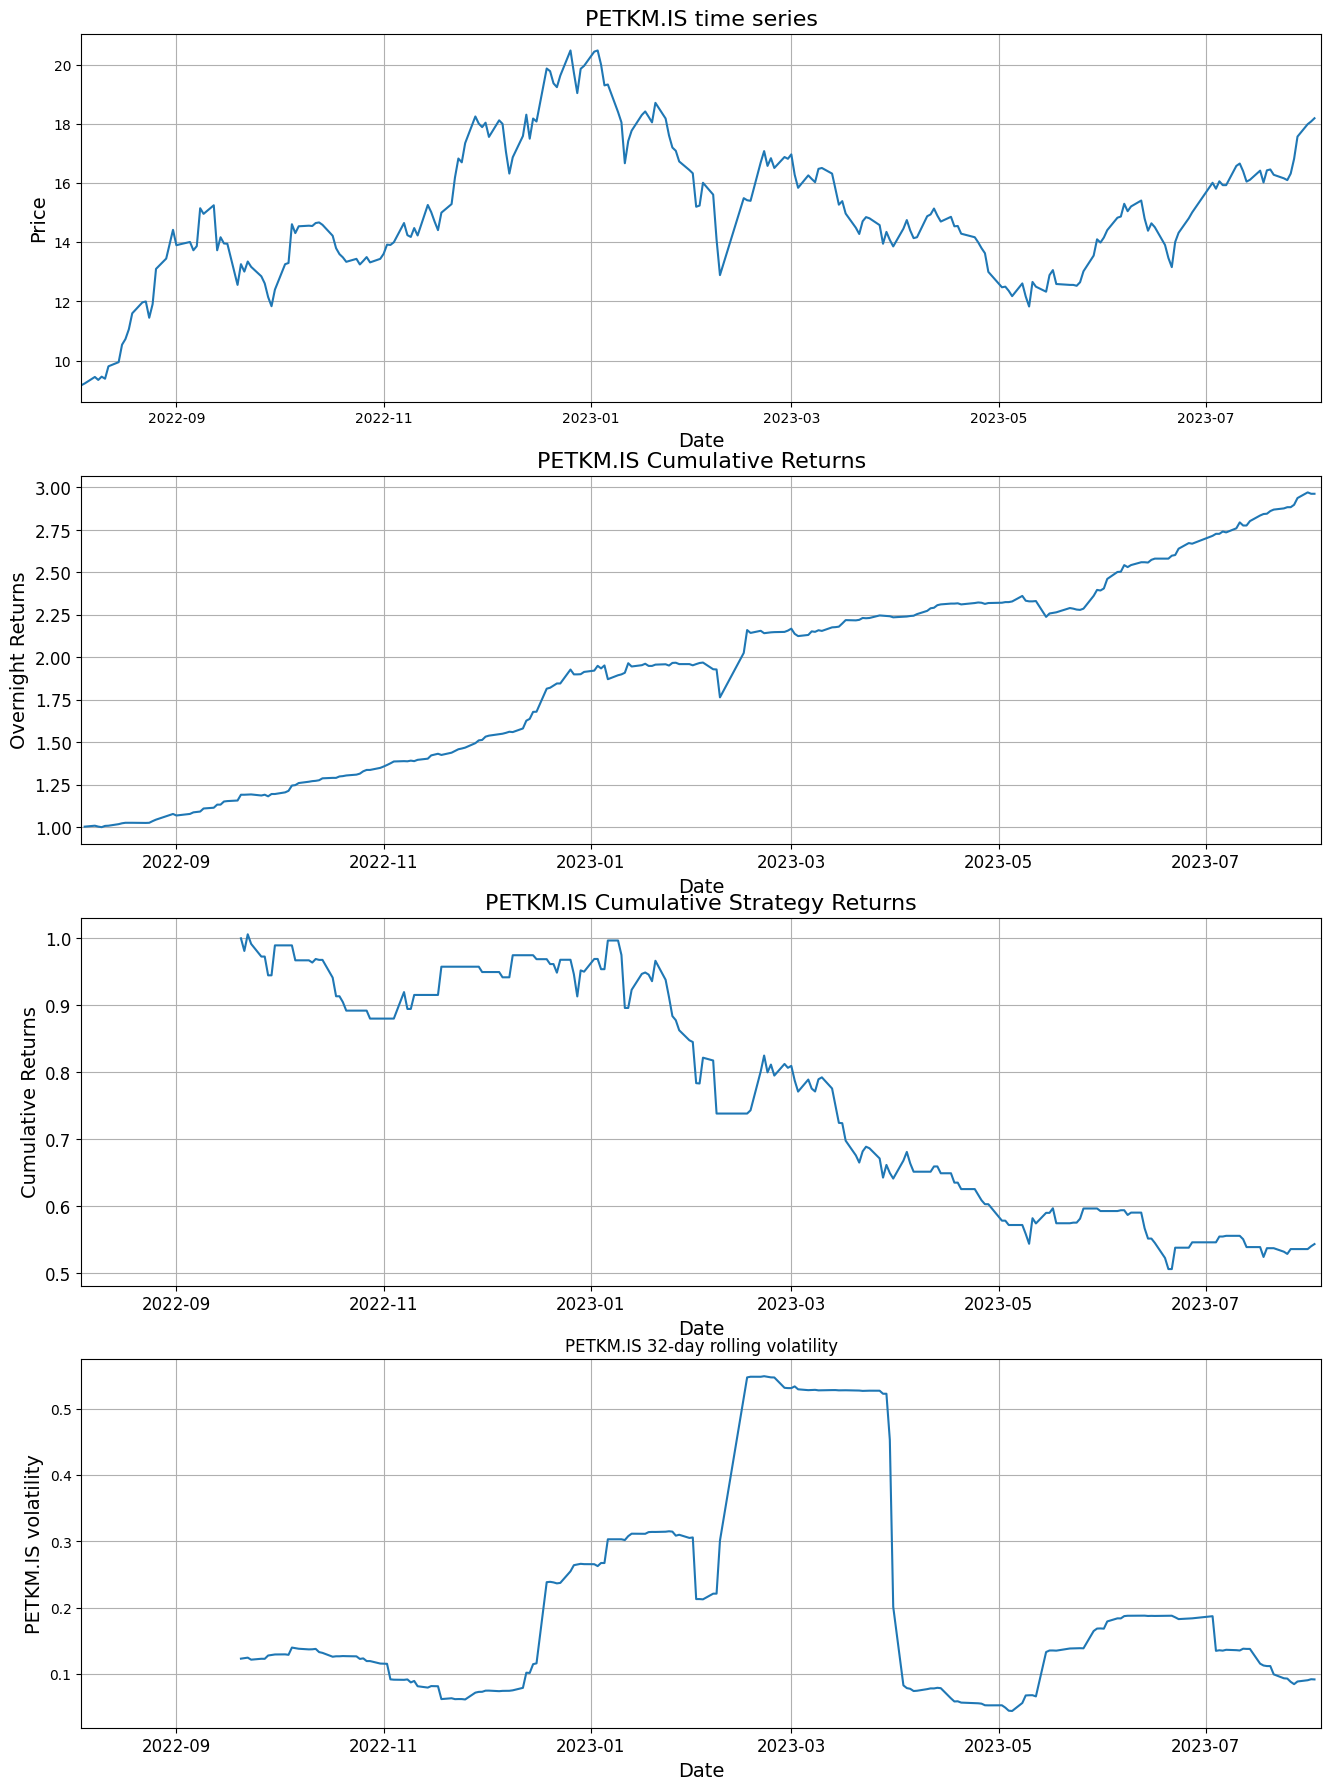

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


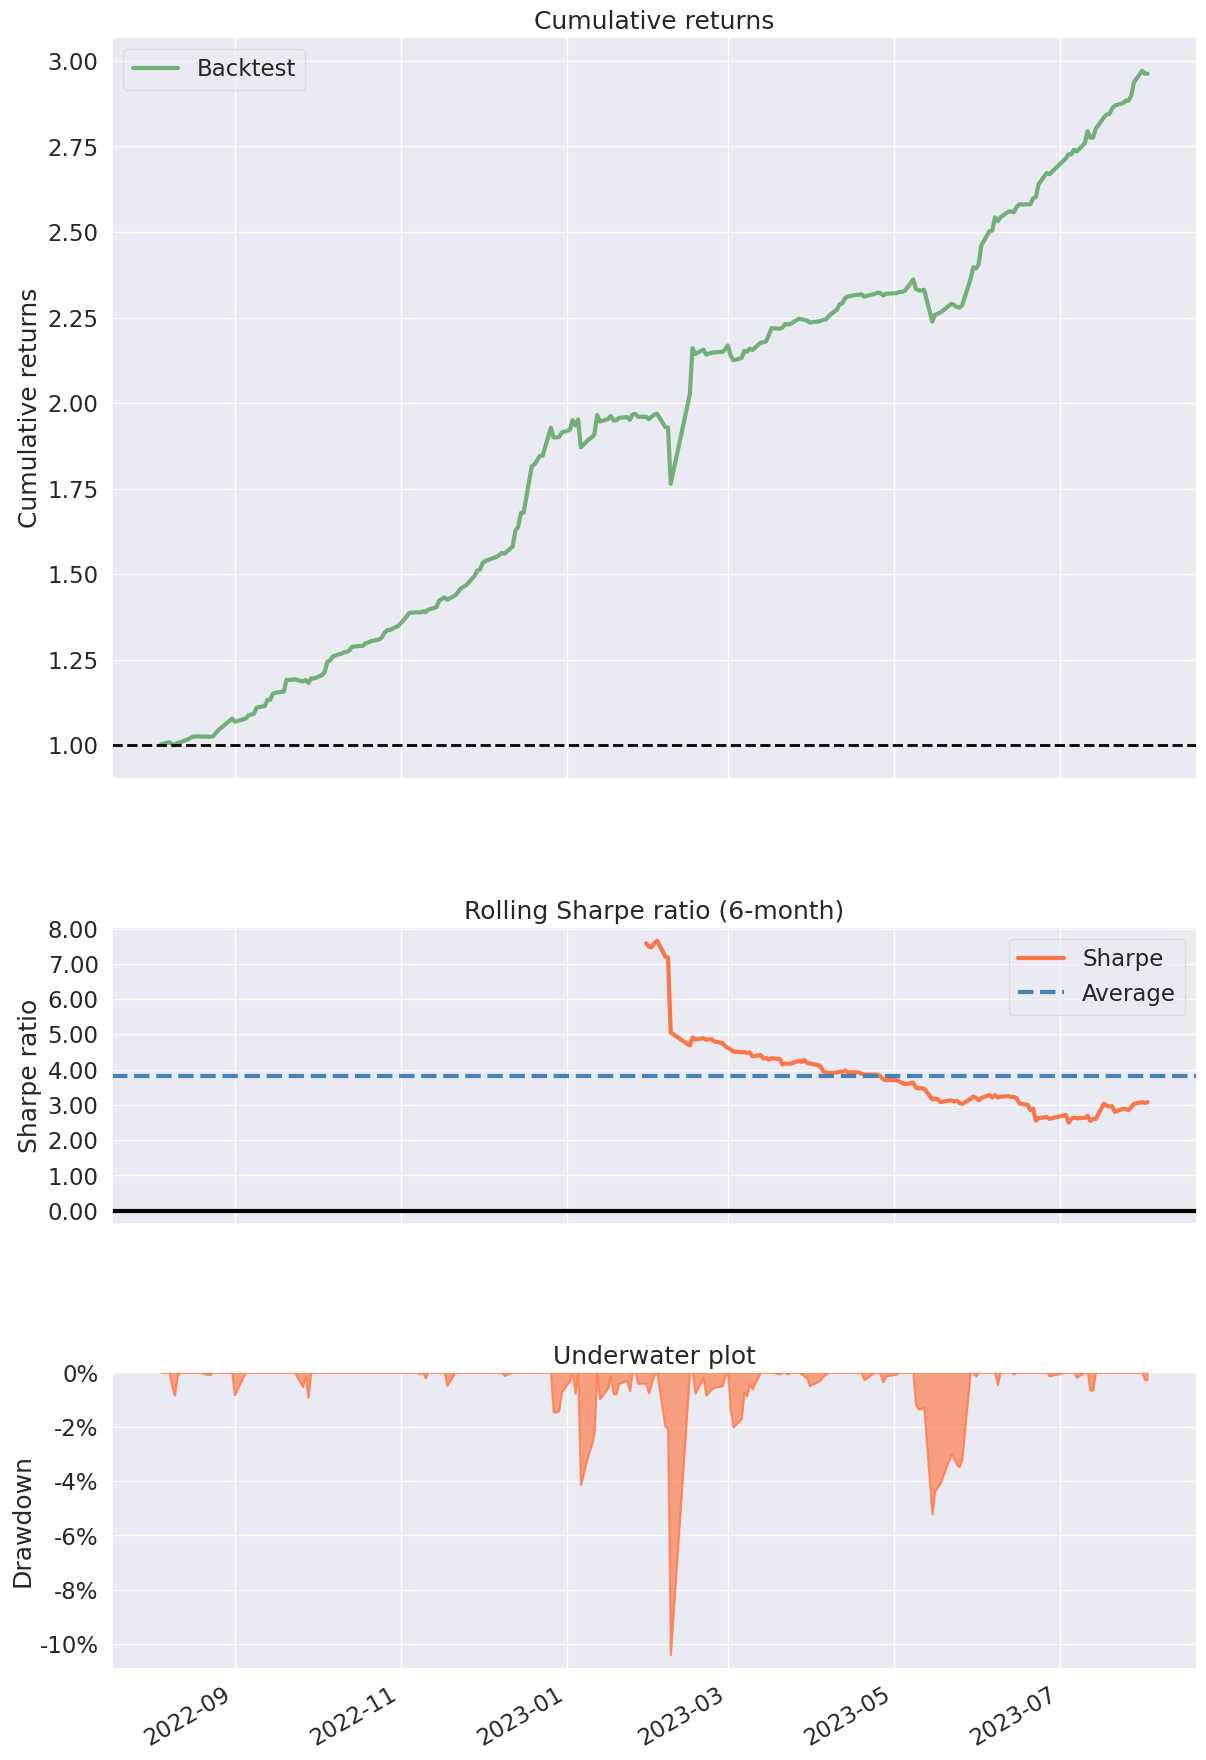

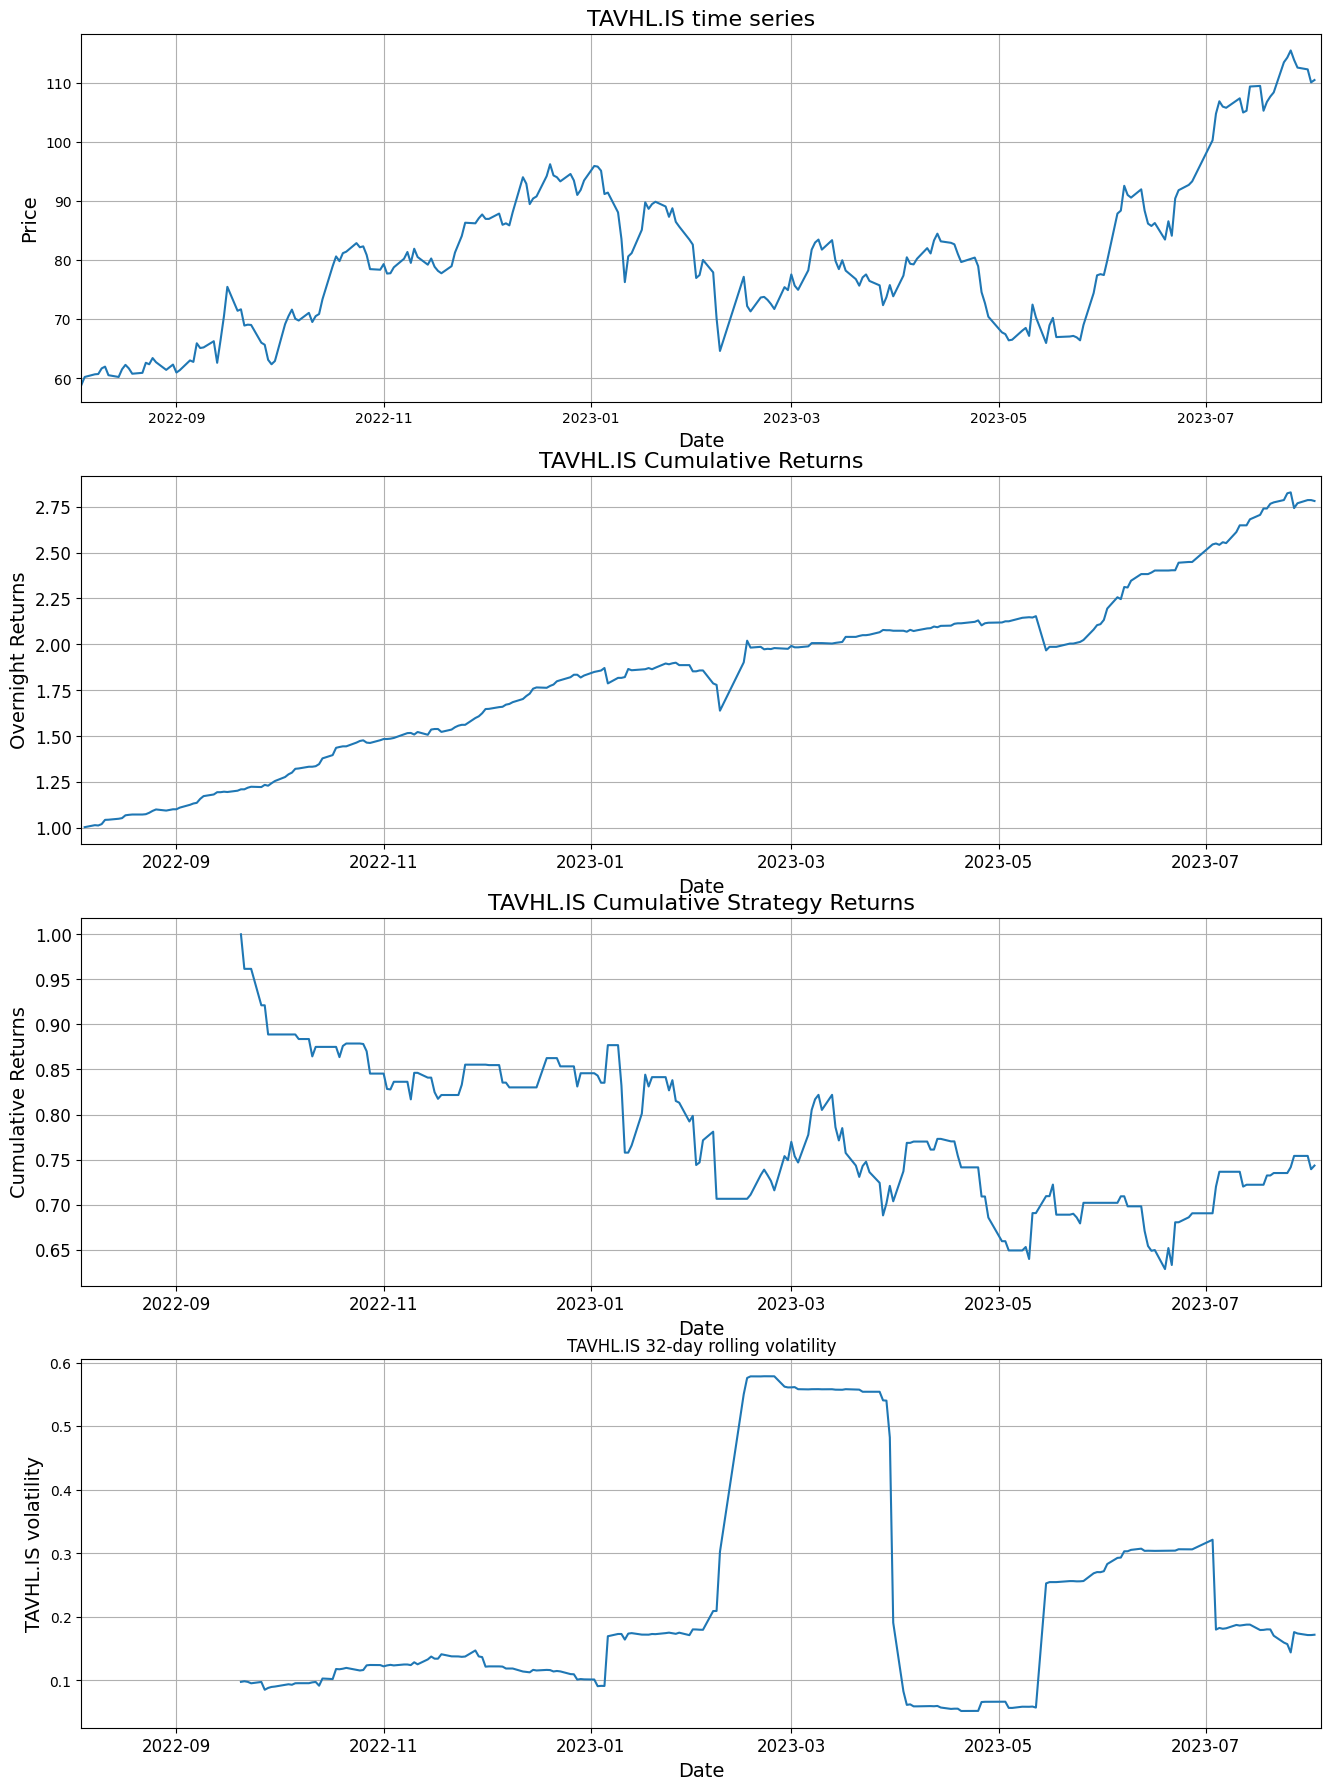

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


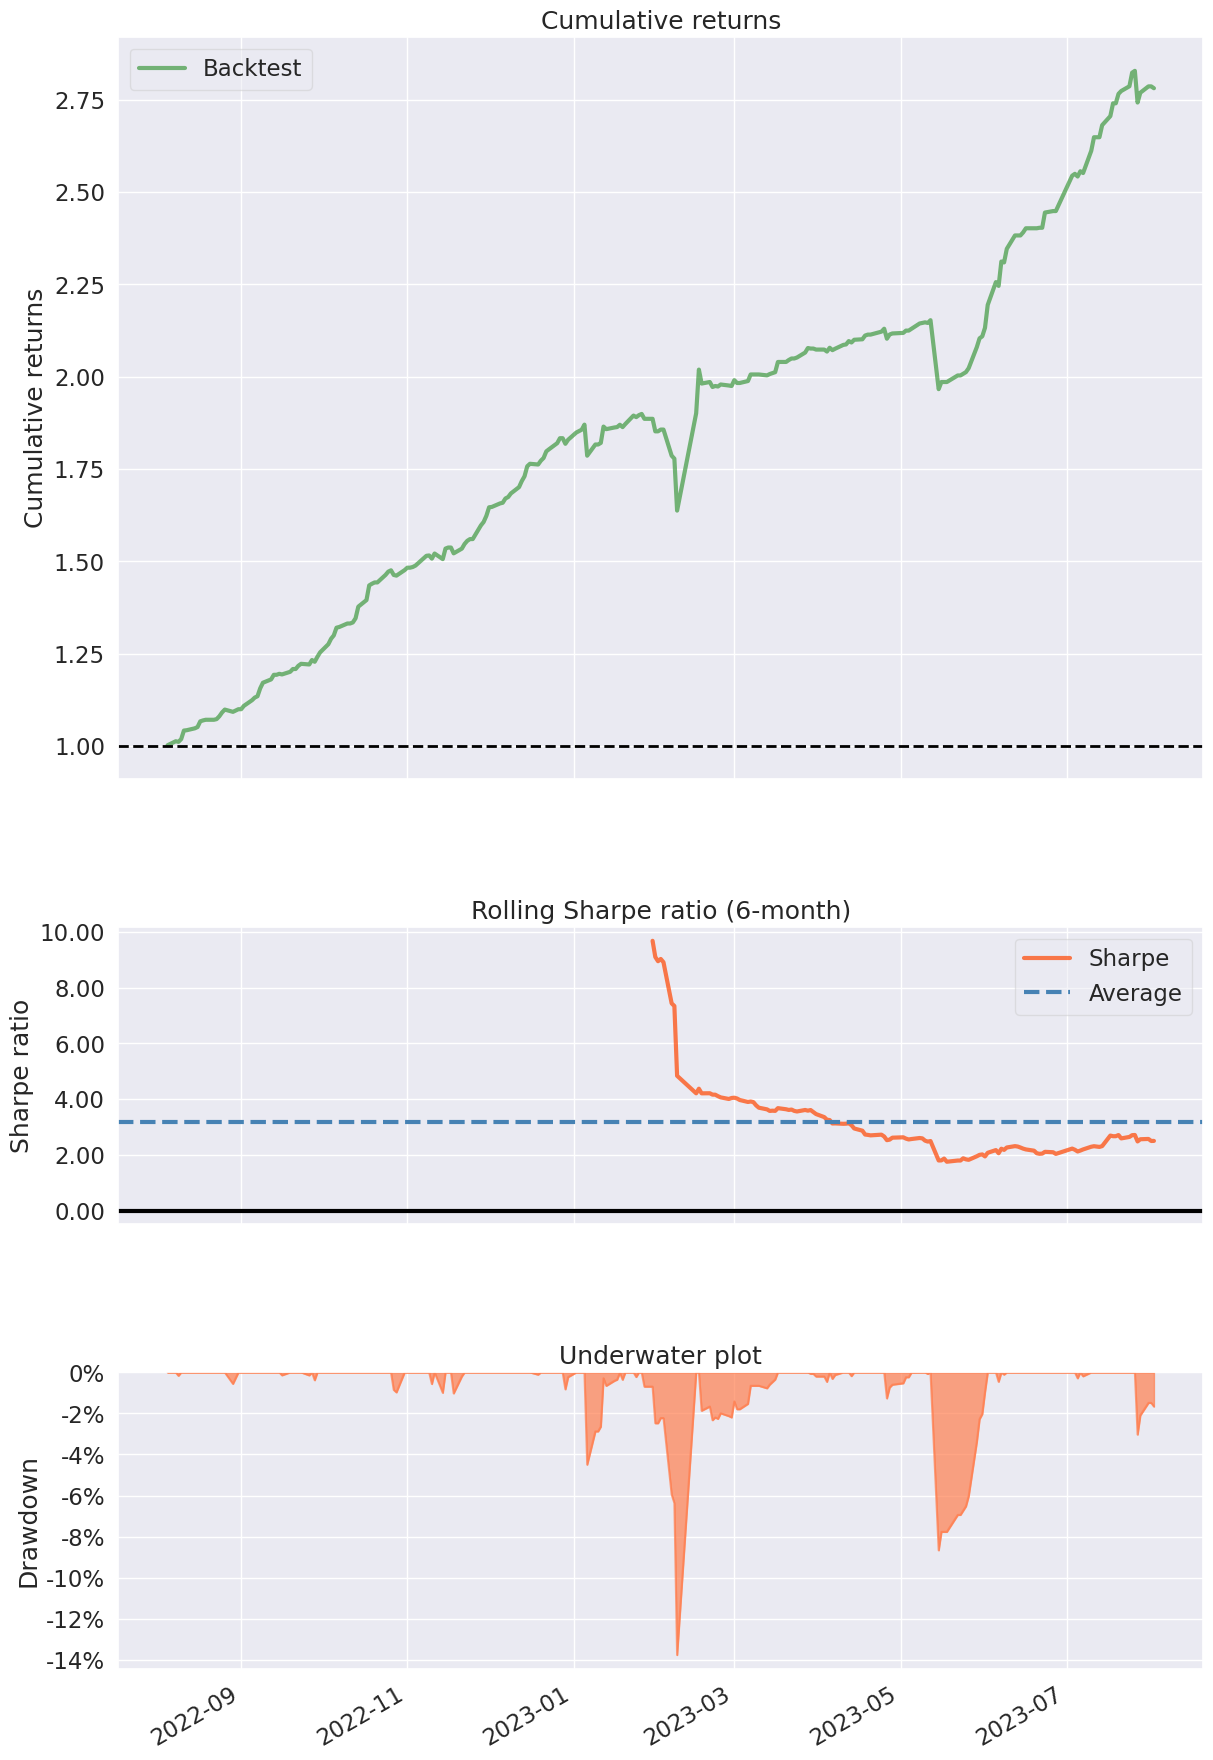

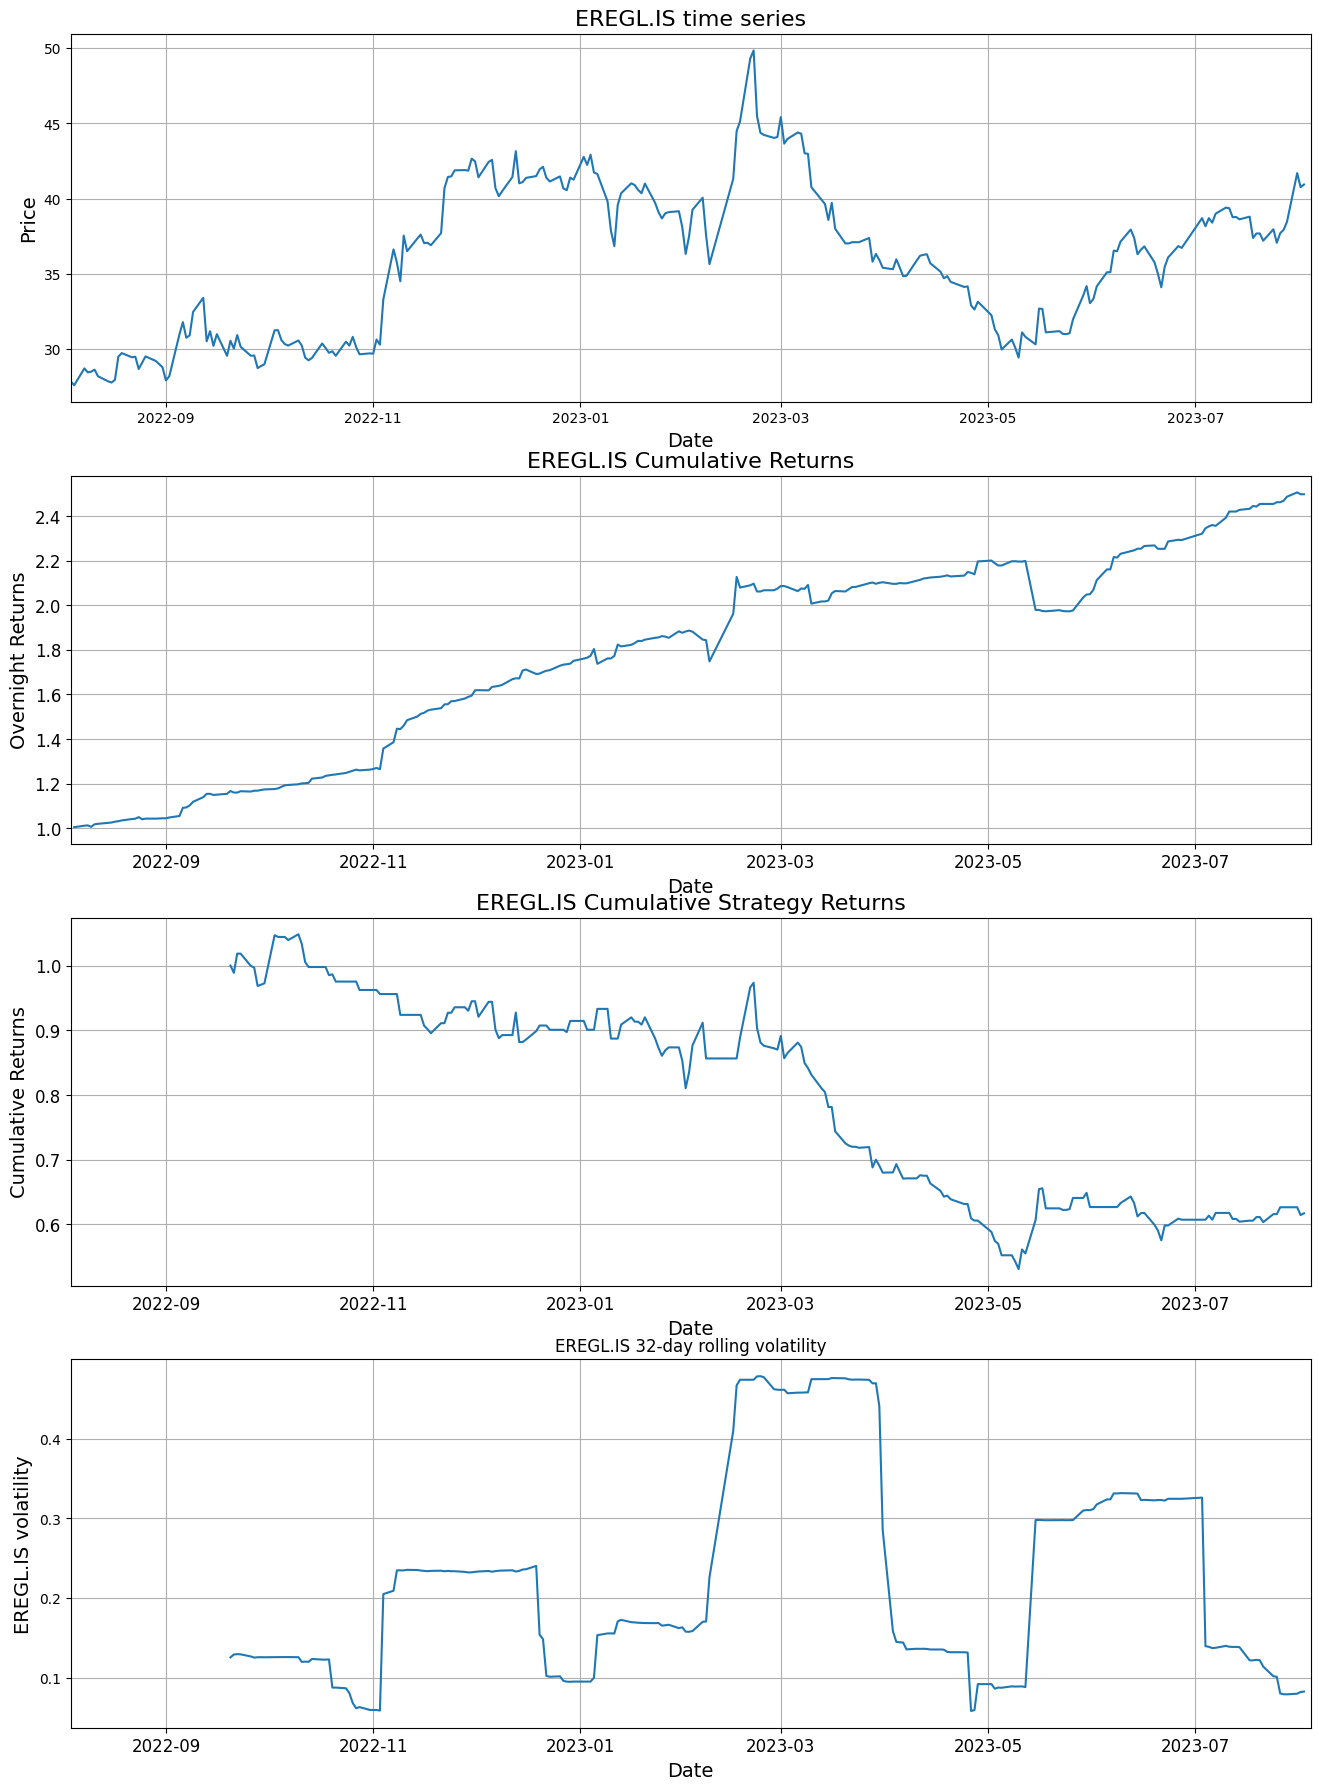

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

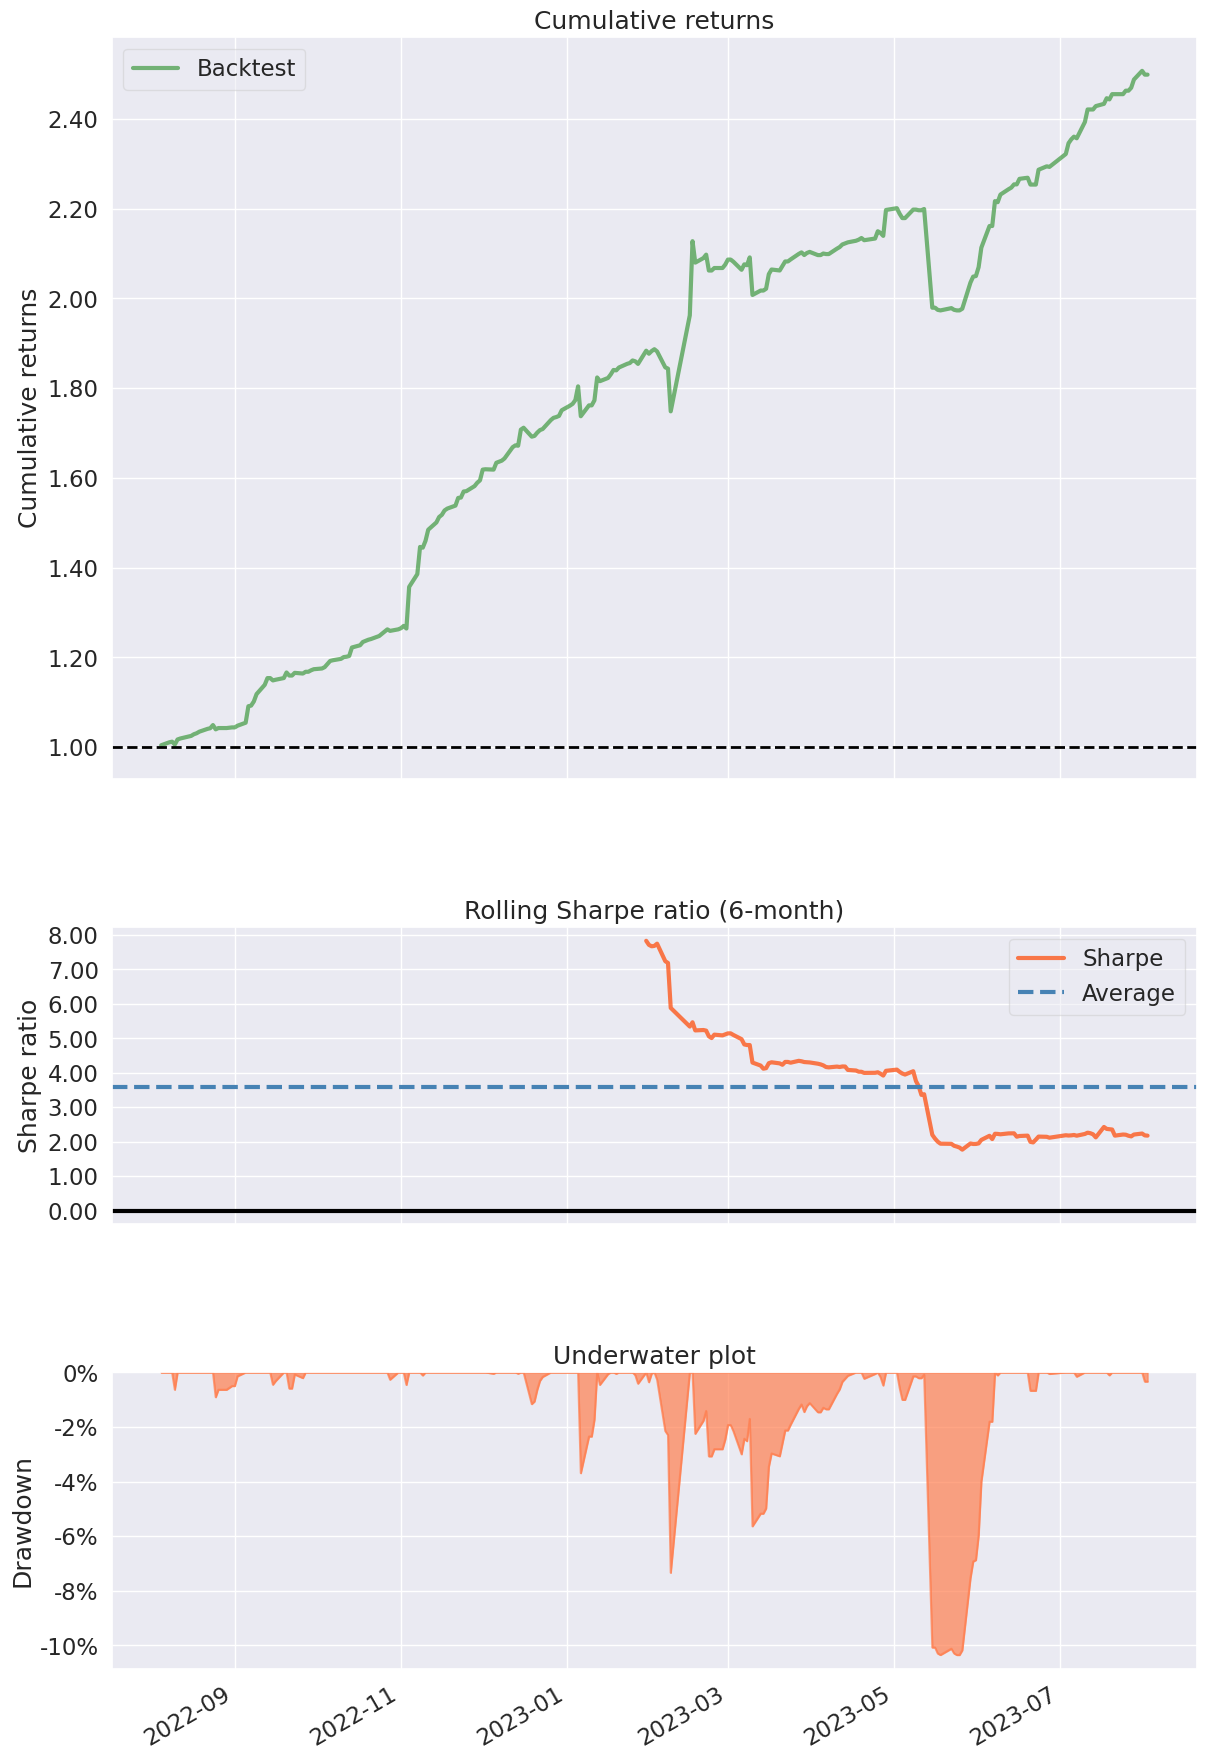

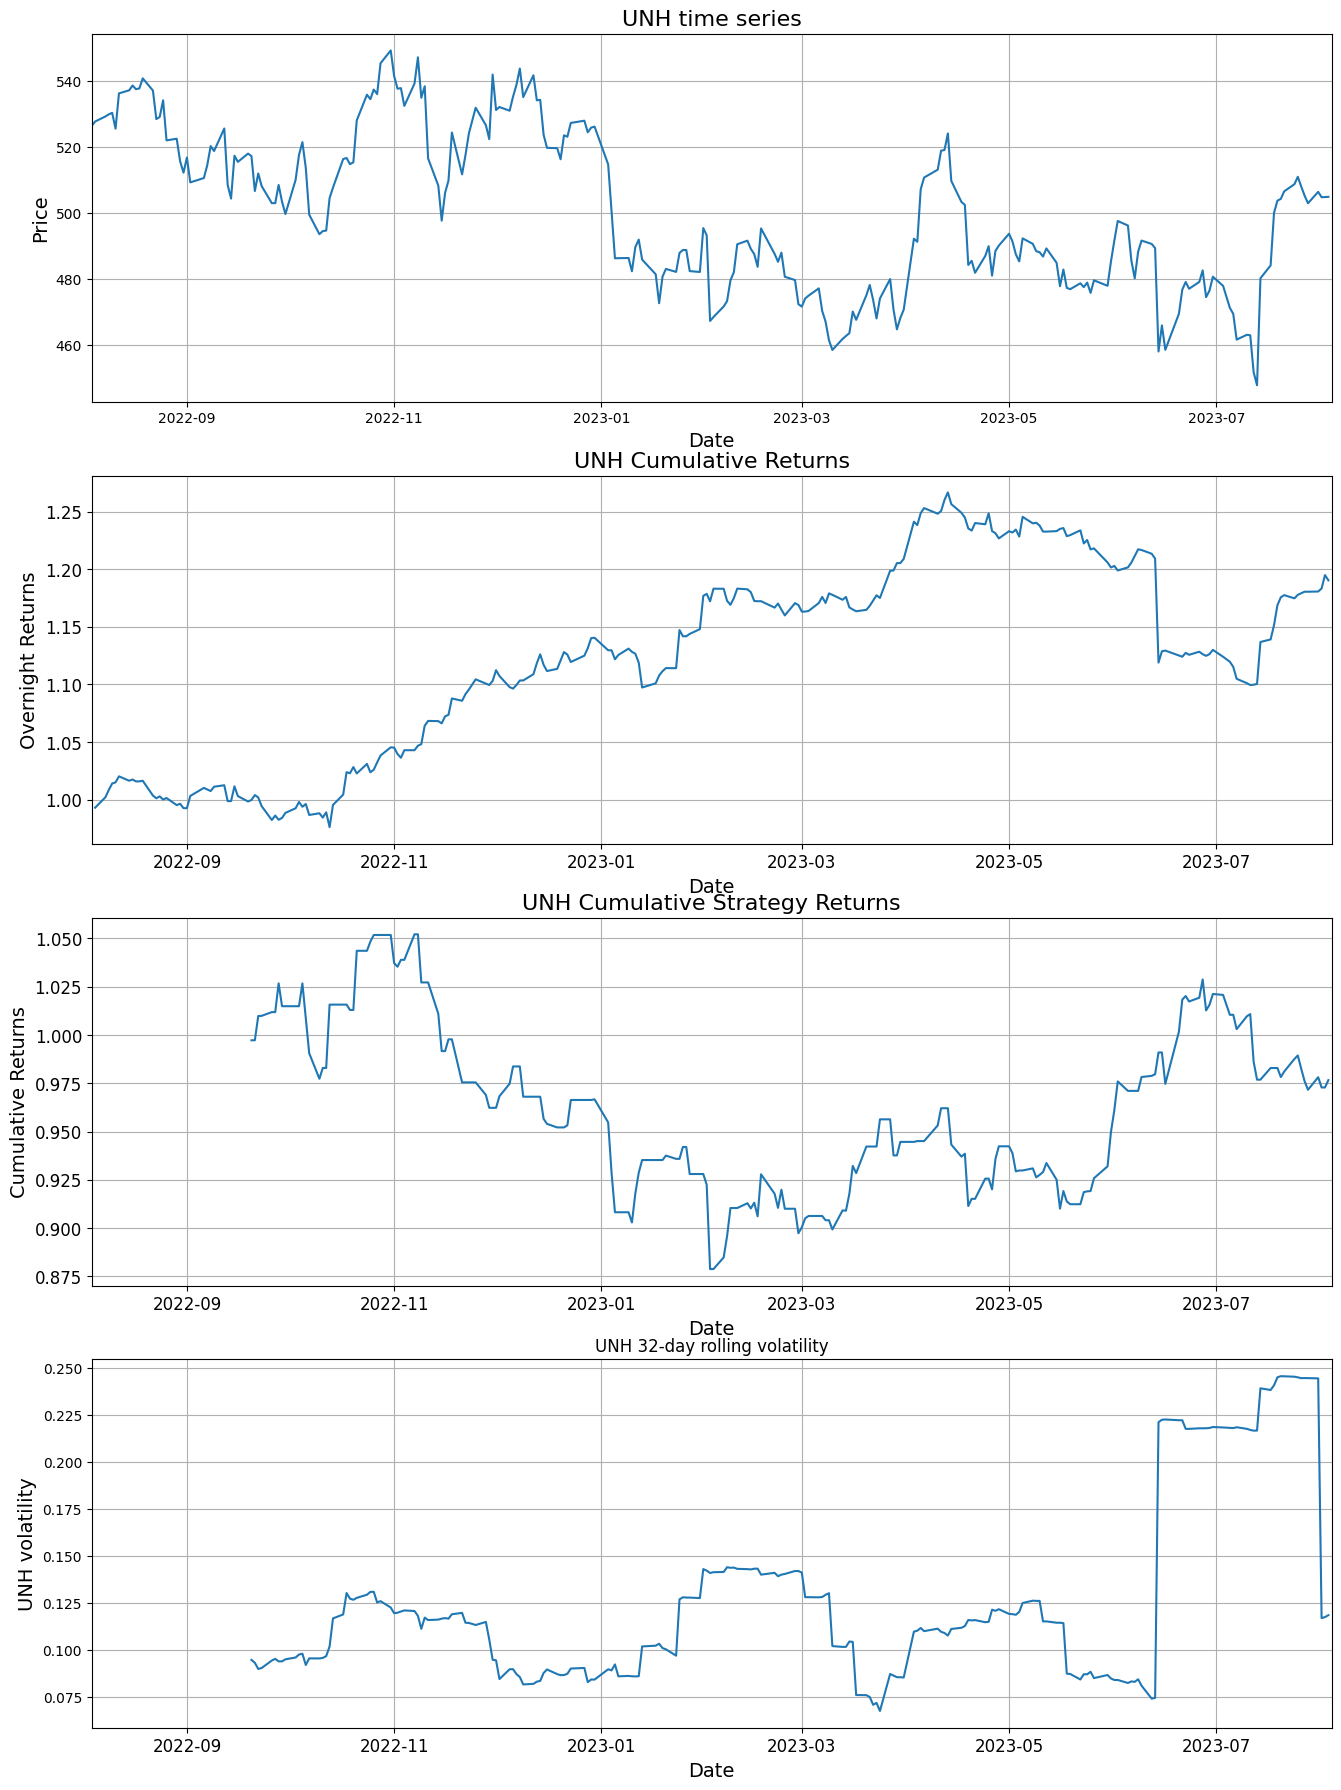

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


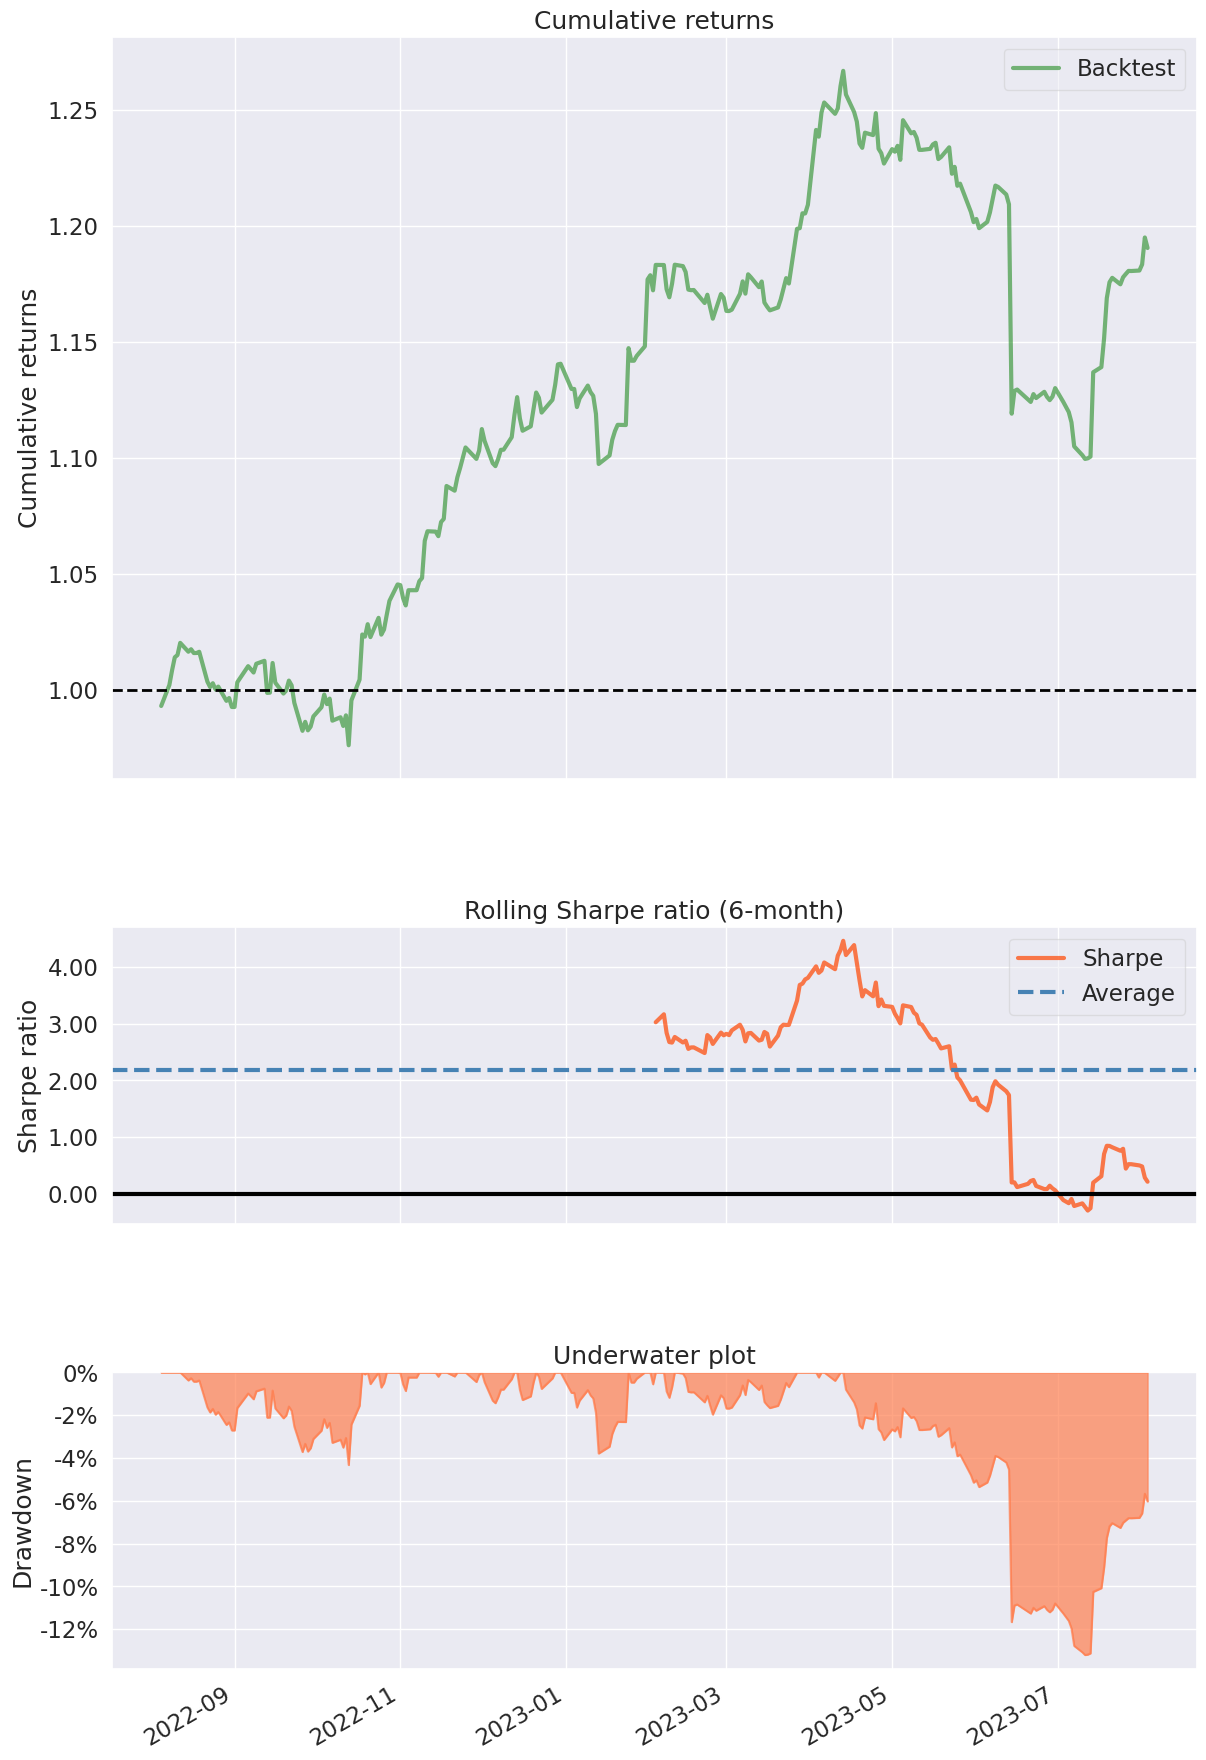

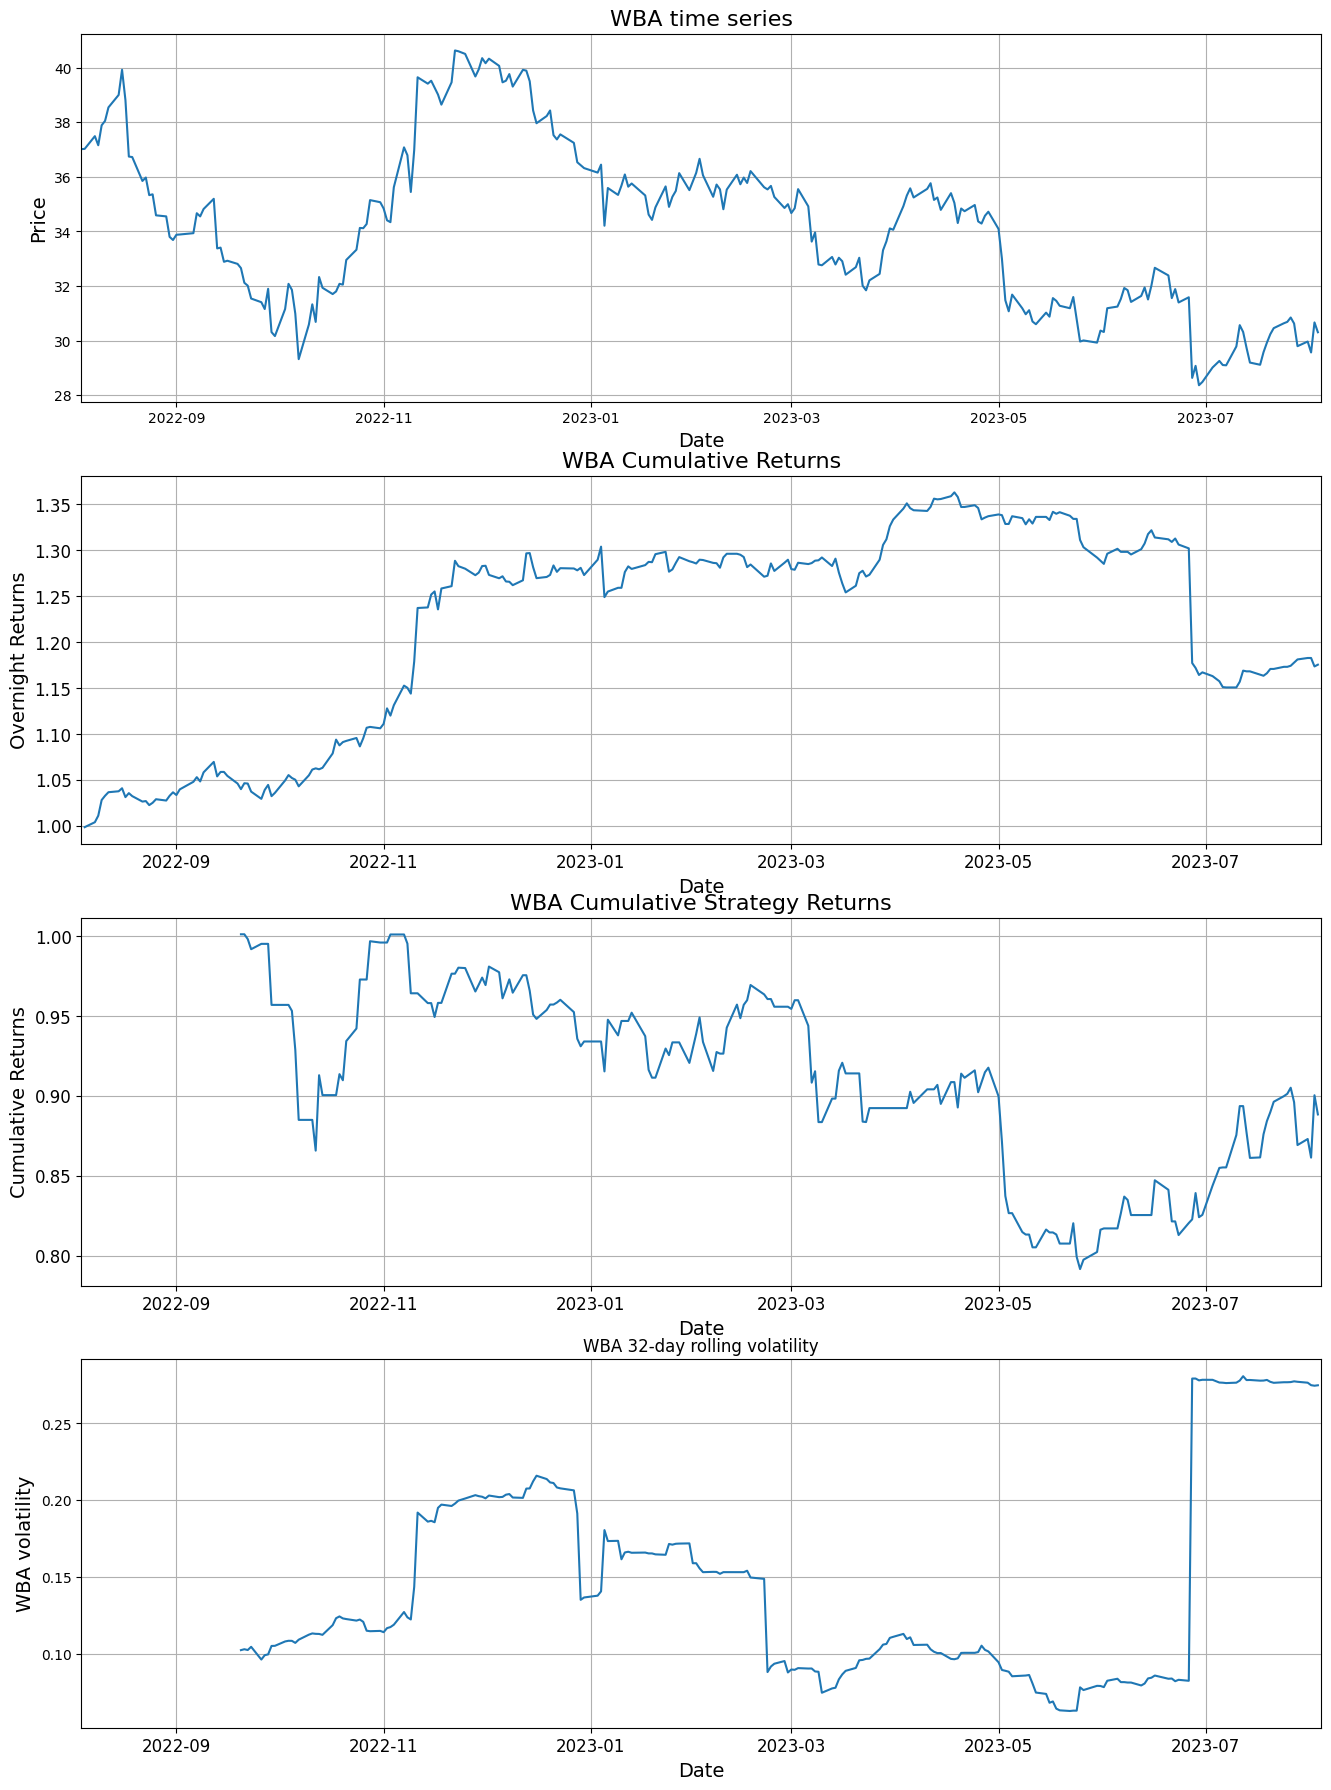

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


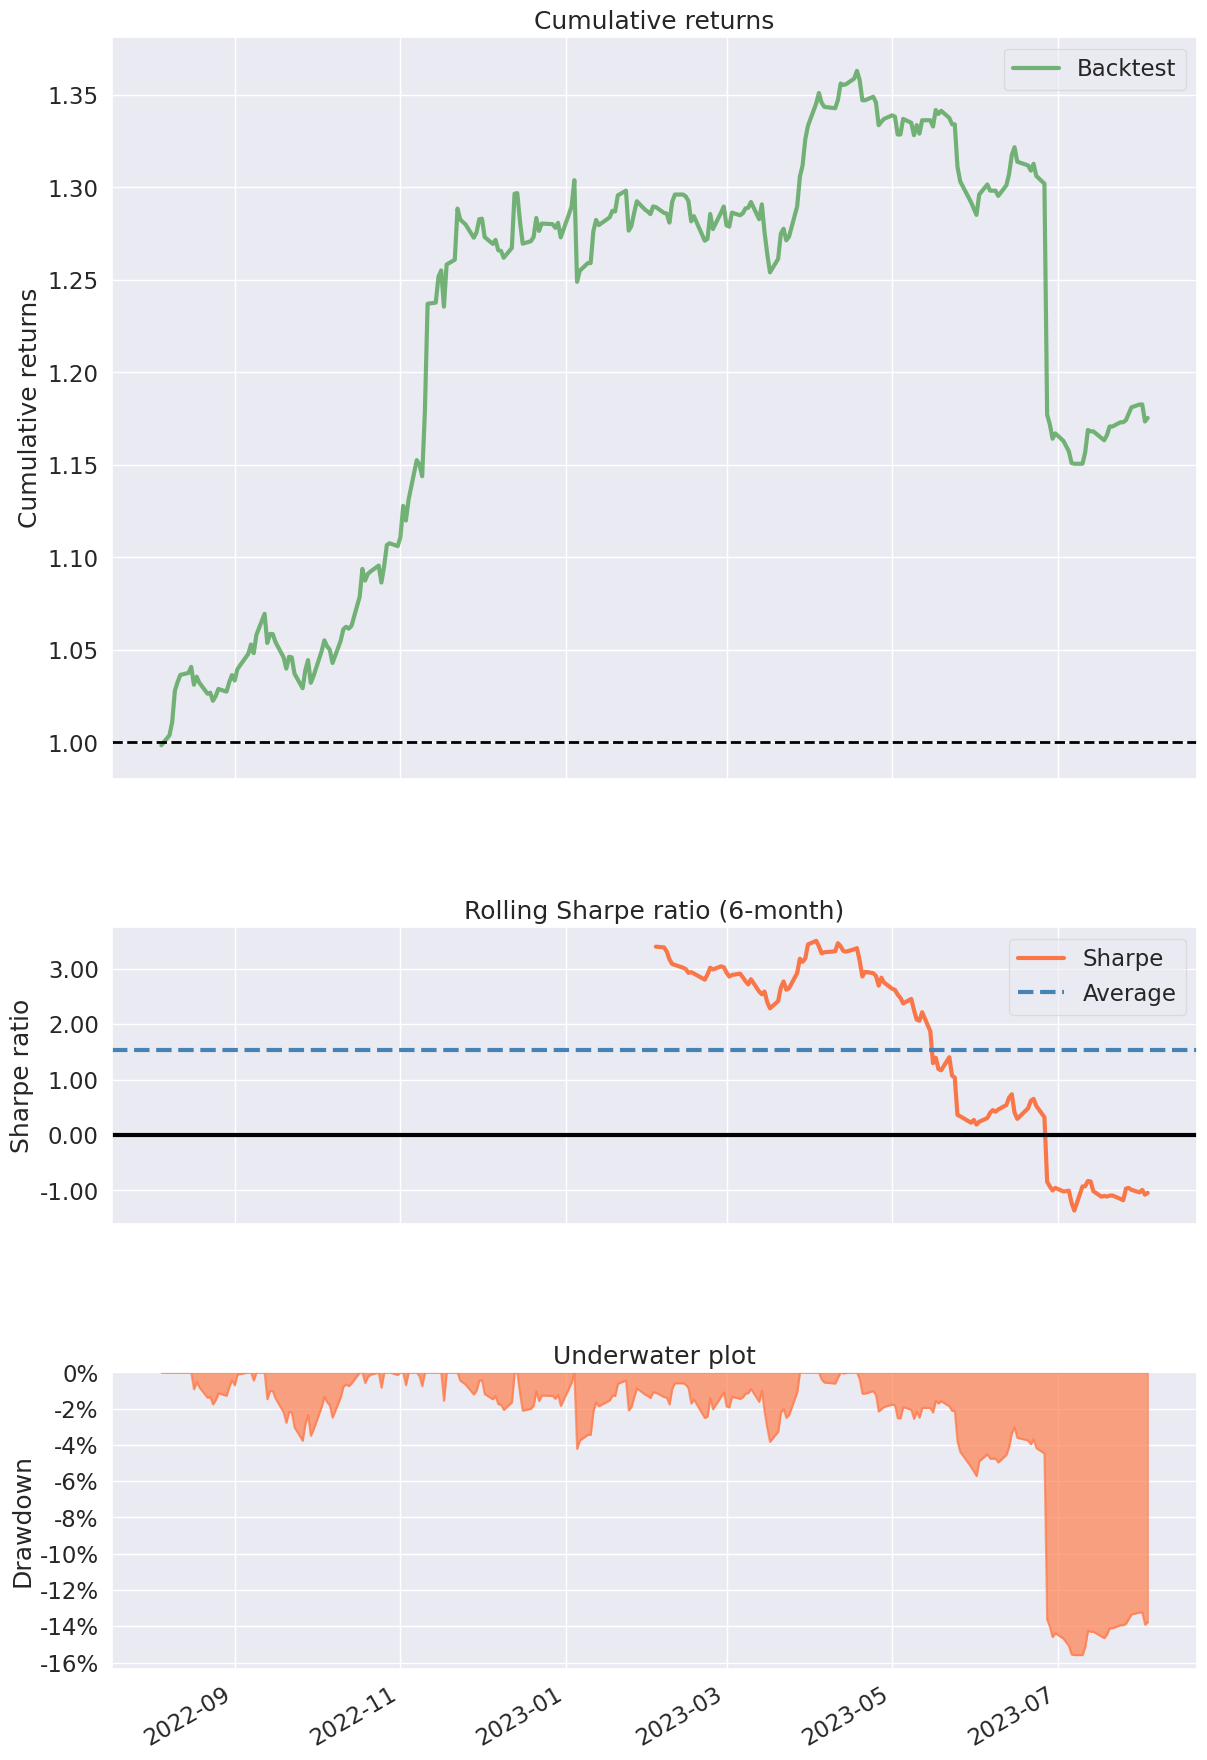

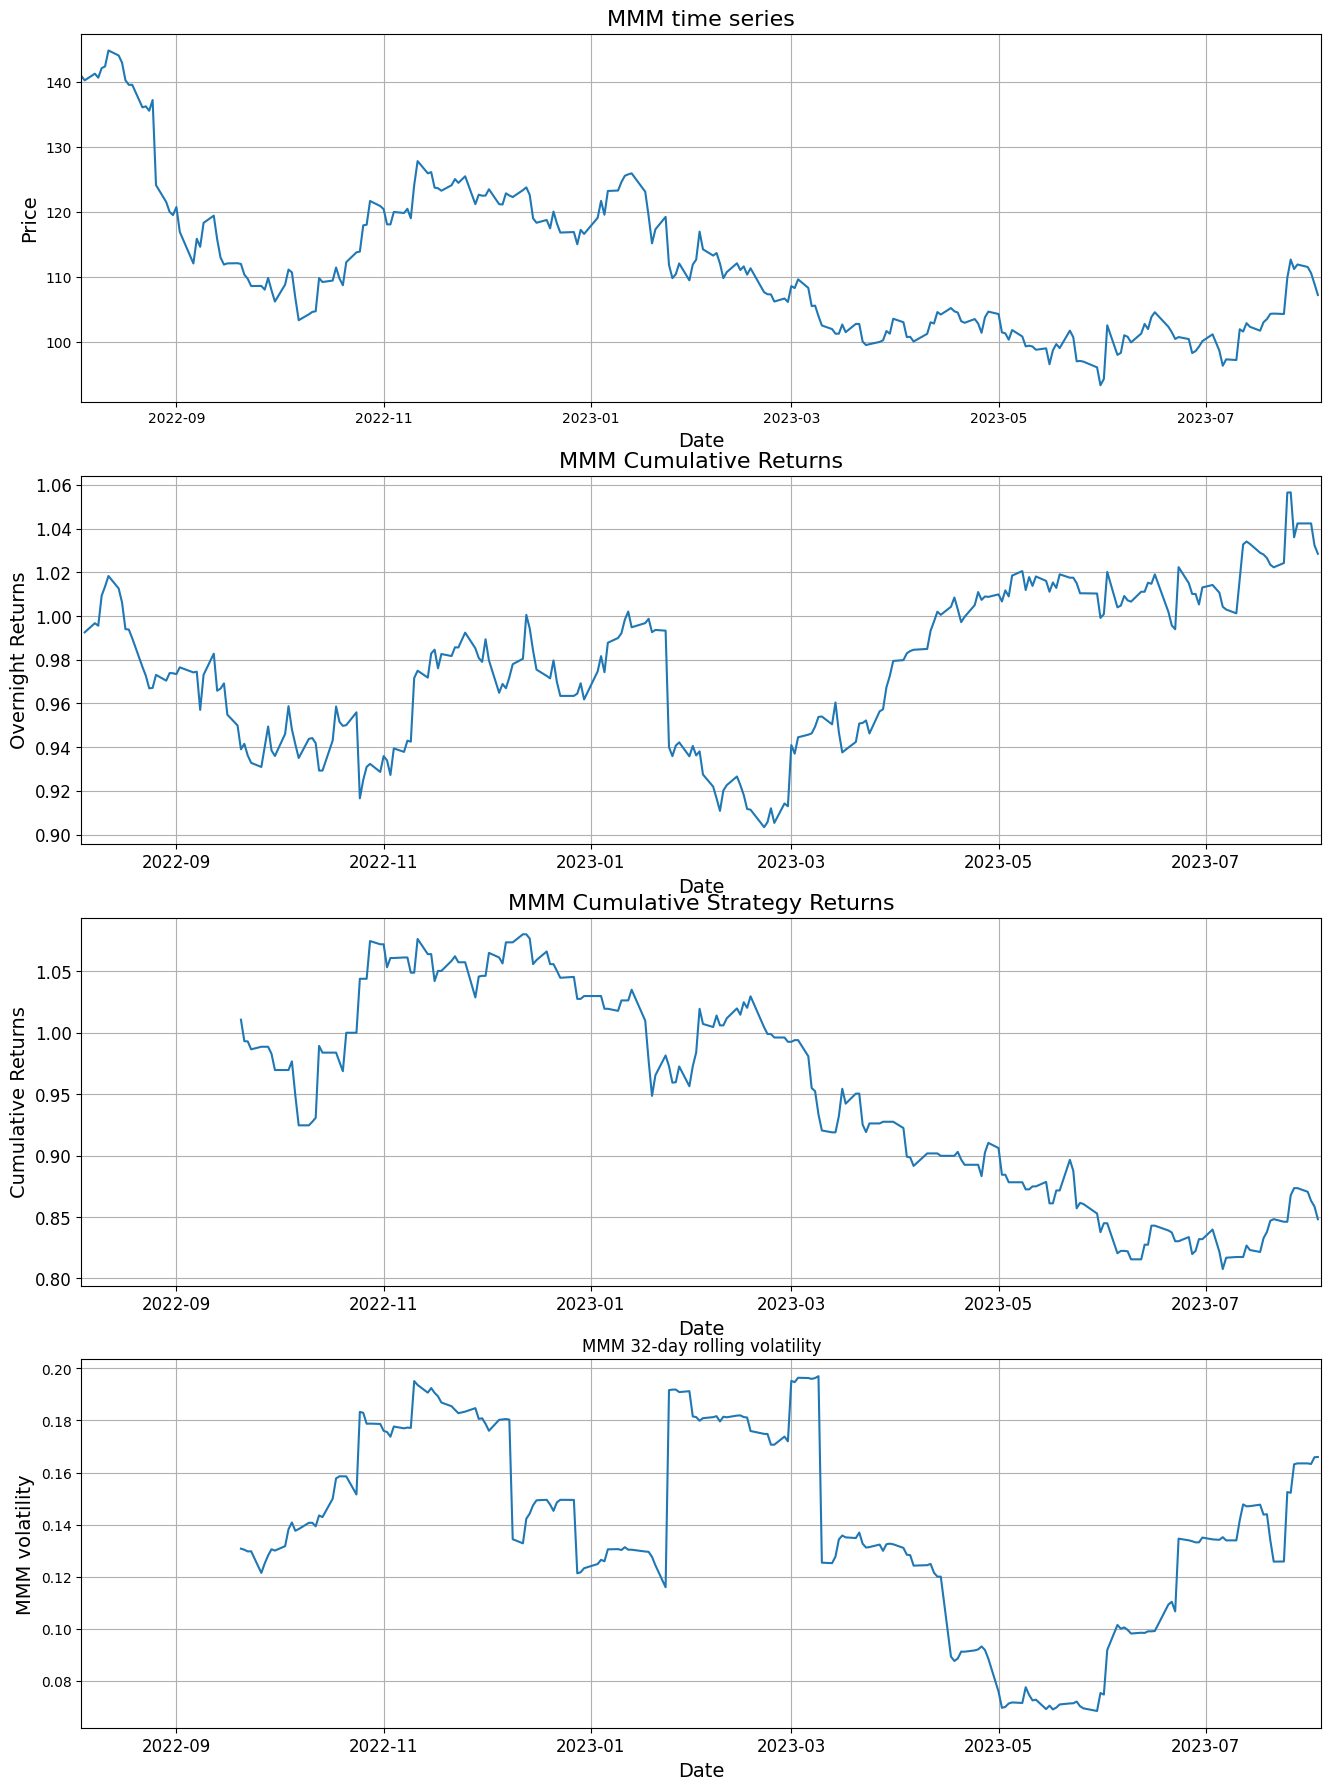

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


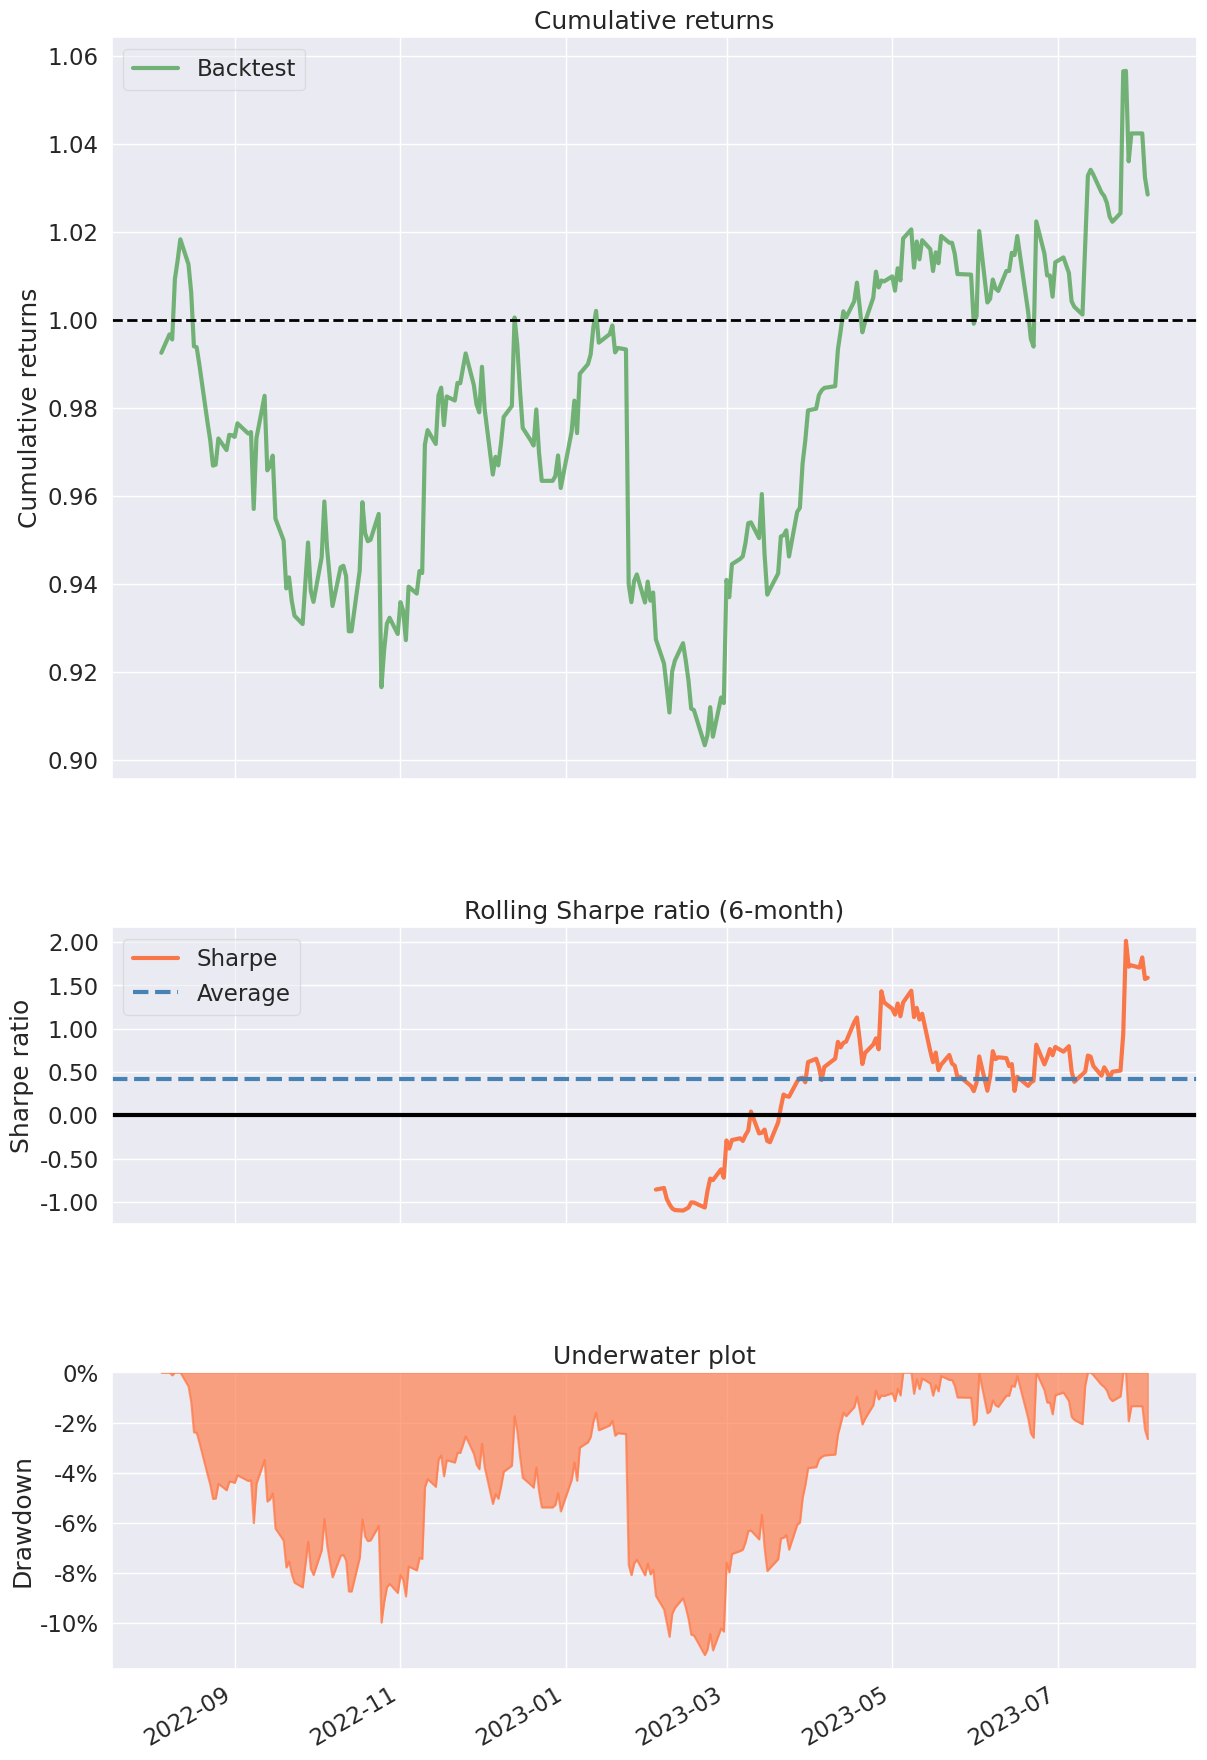

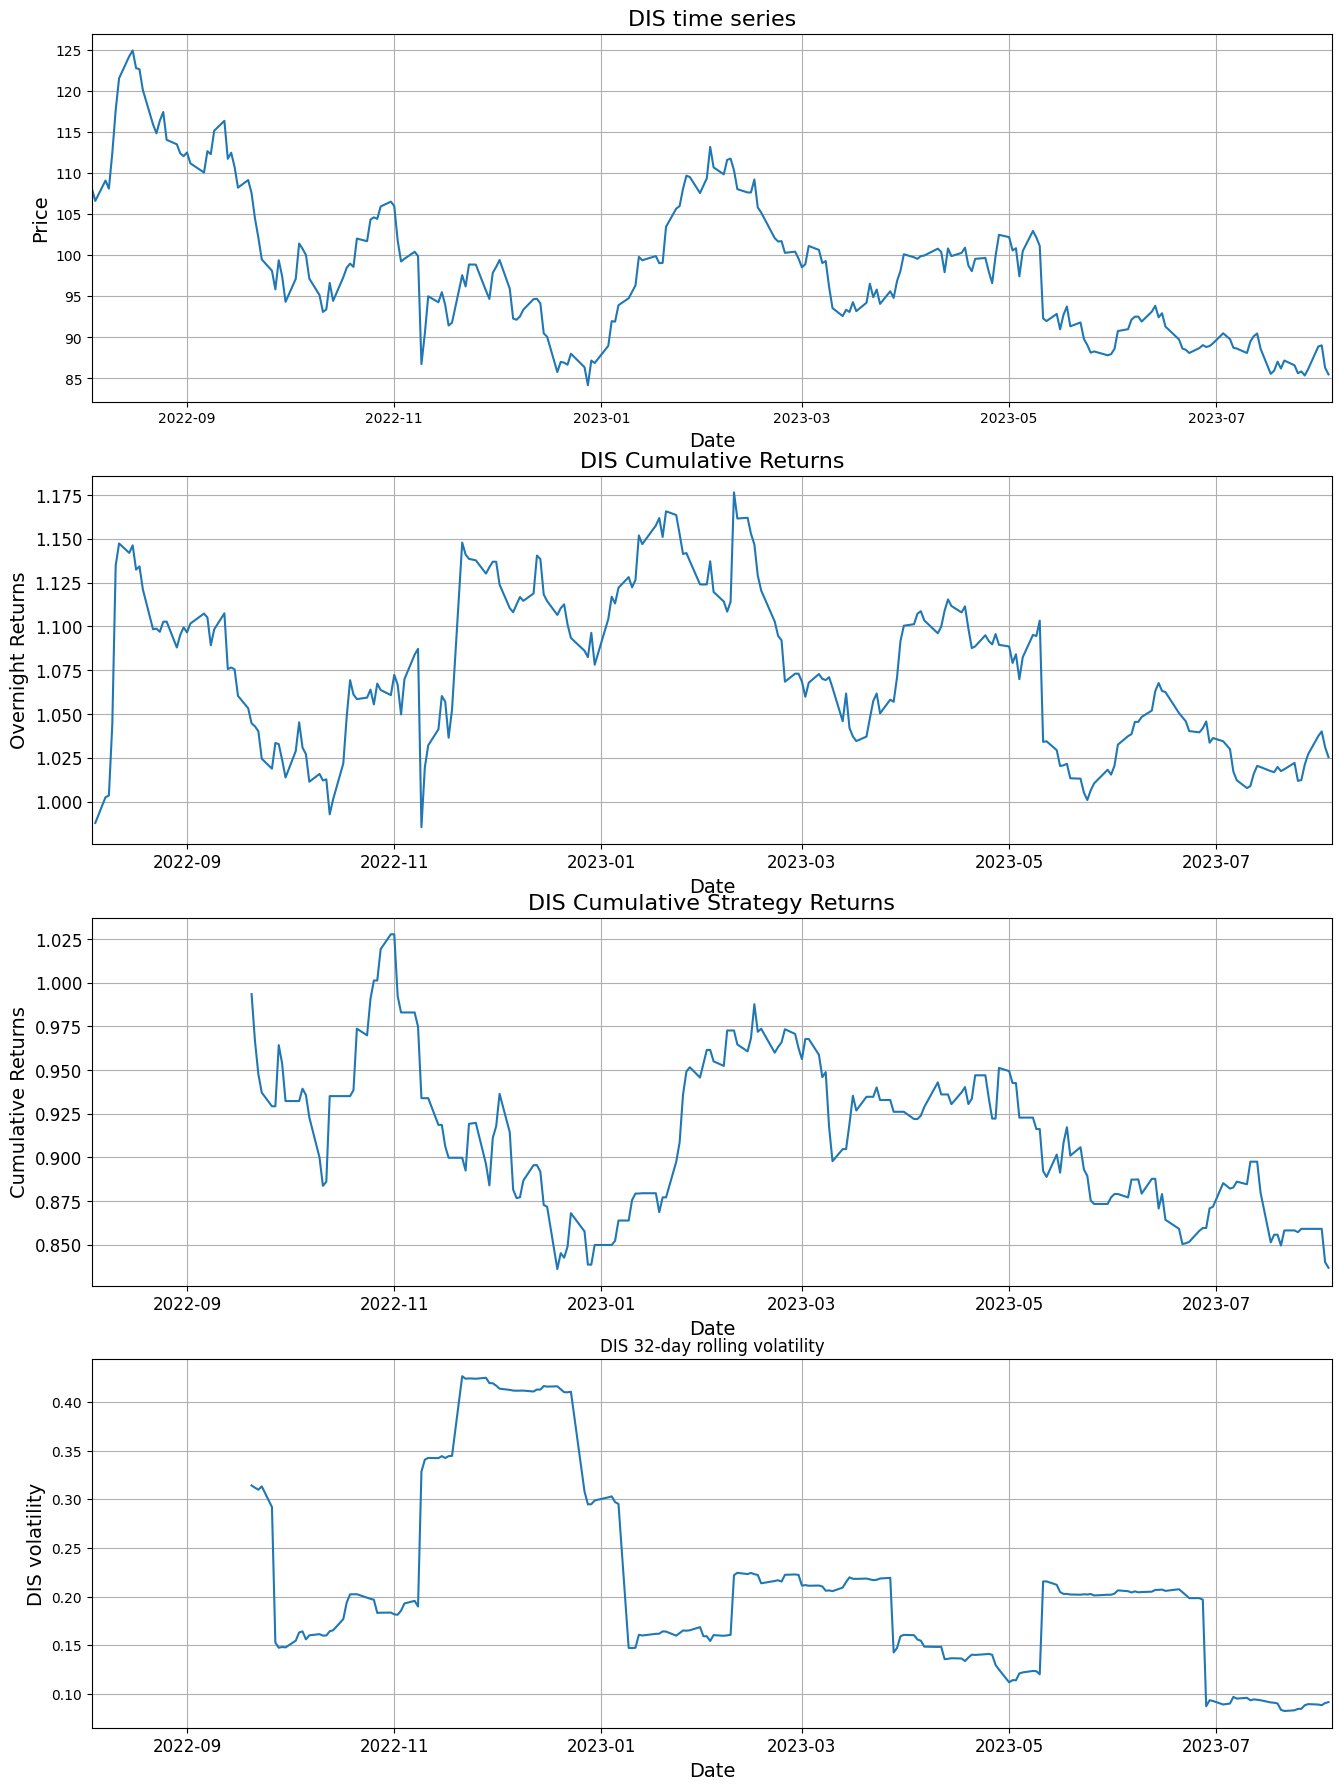

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%***********************]  1 of 1 completed


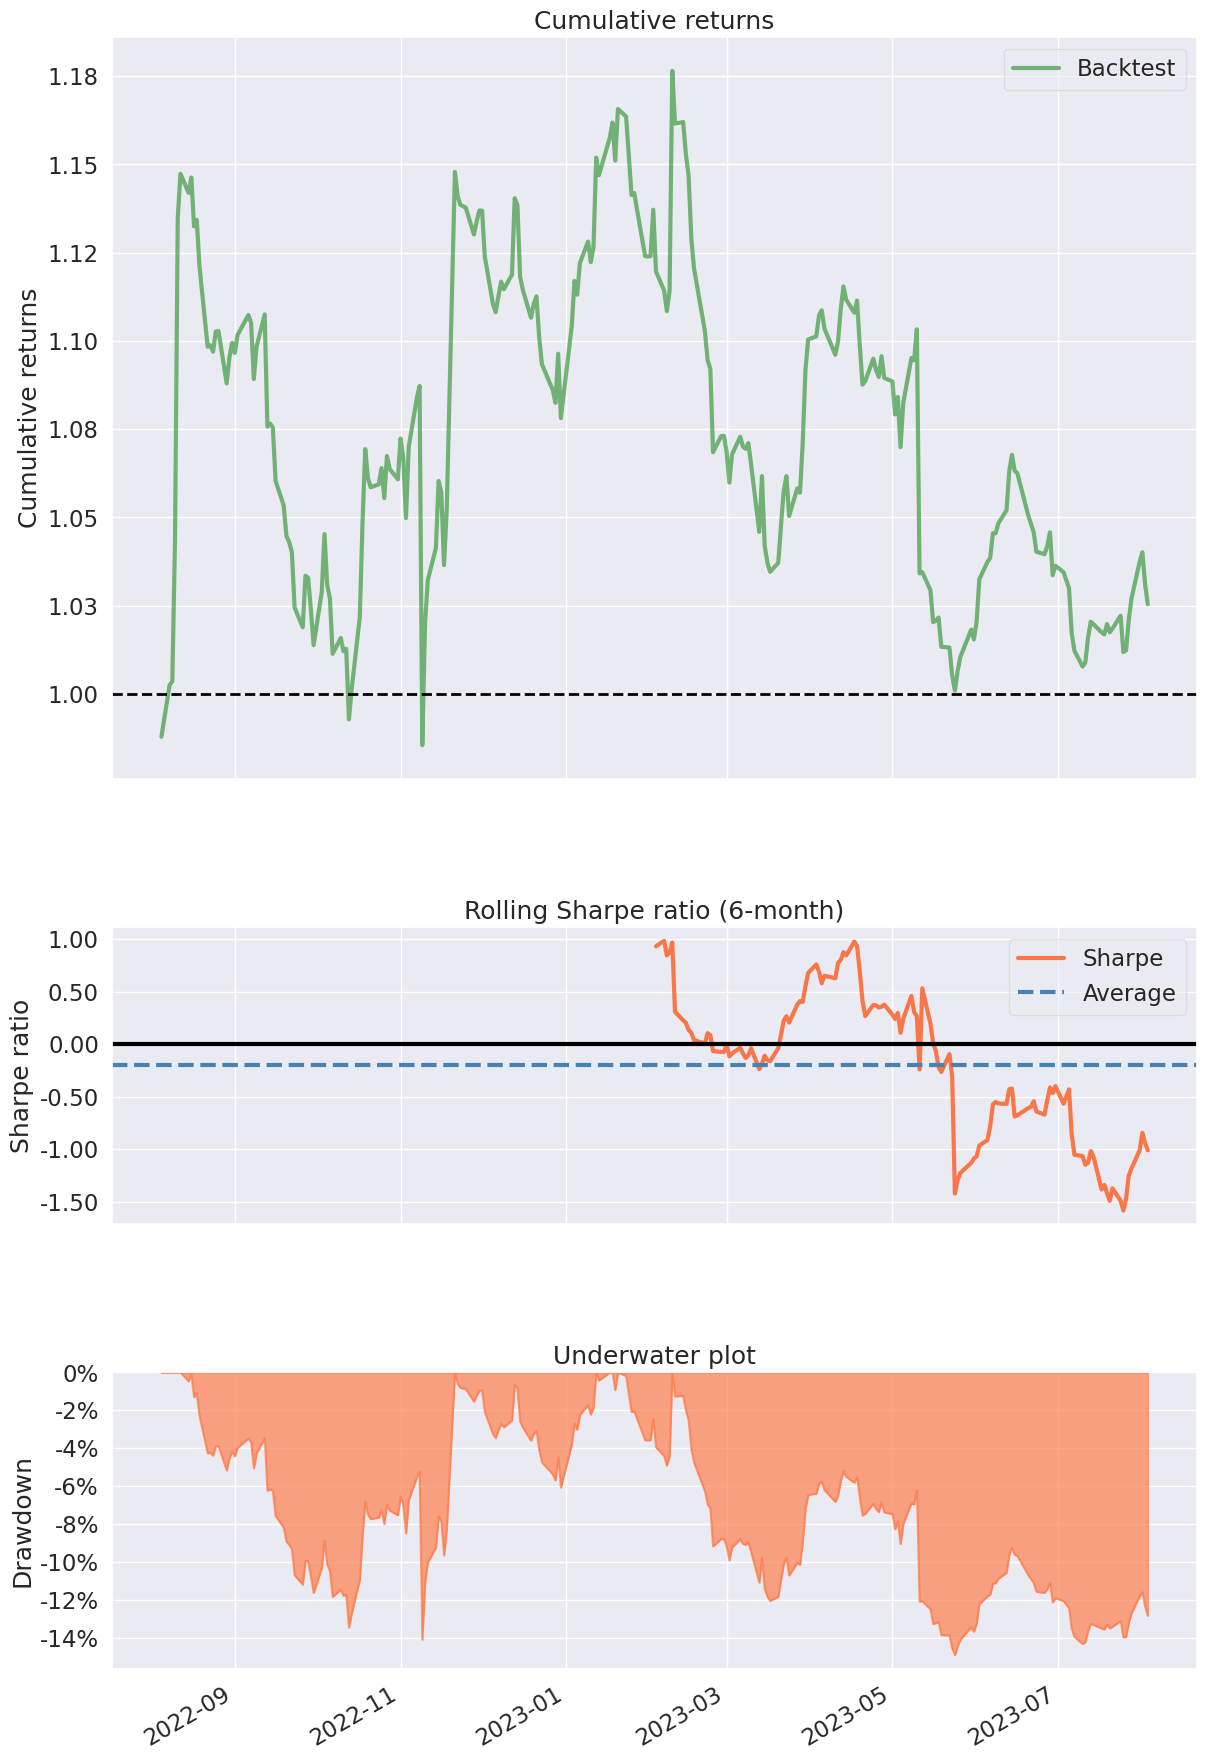

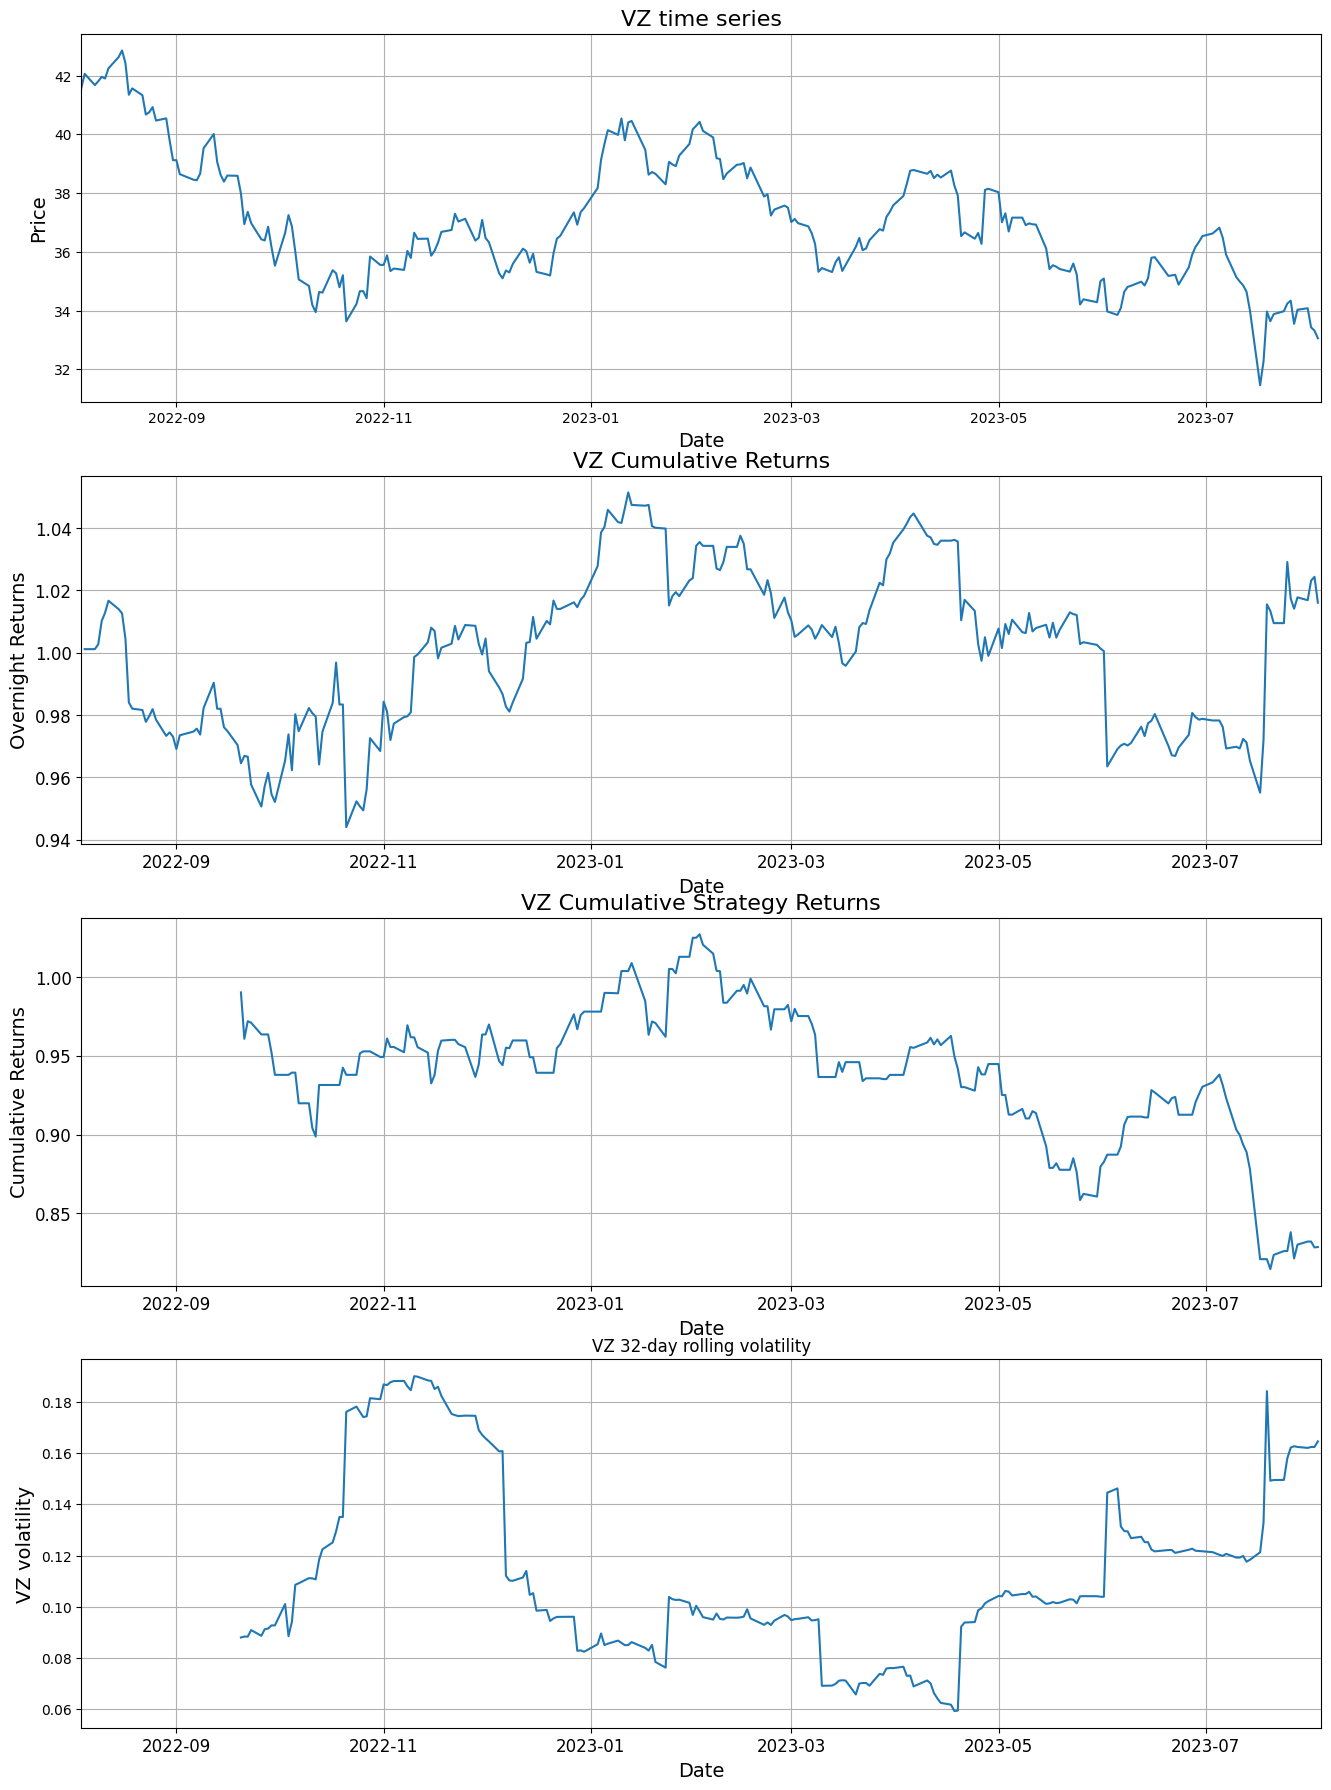

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


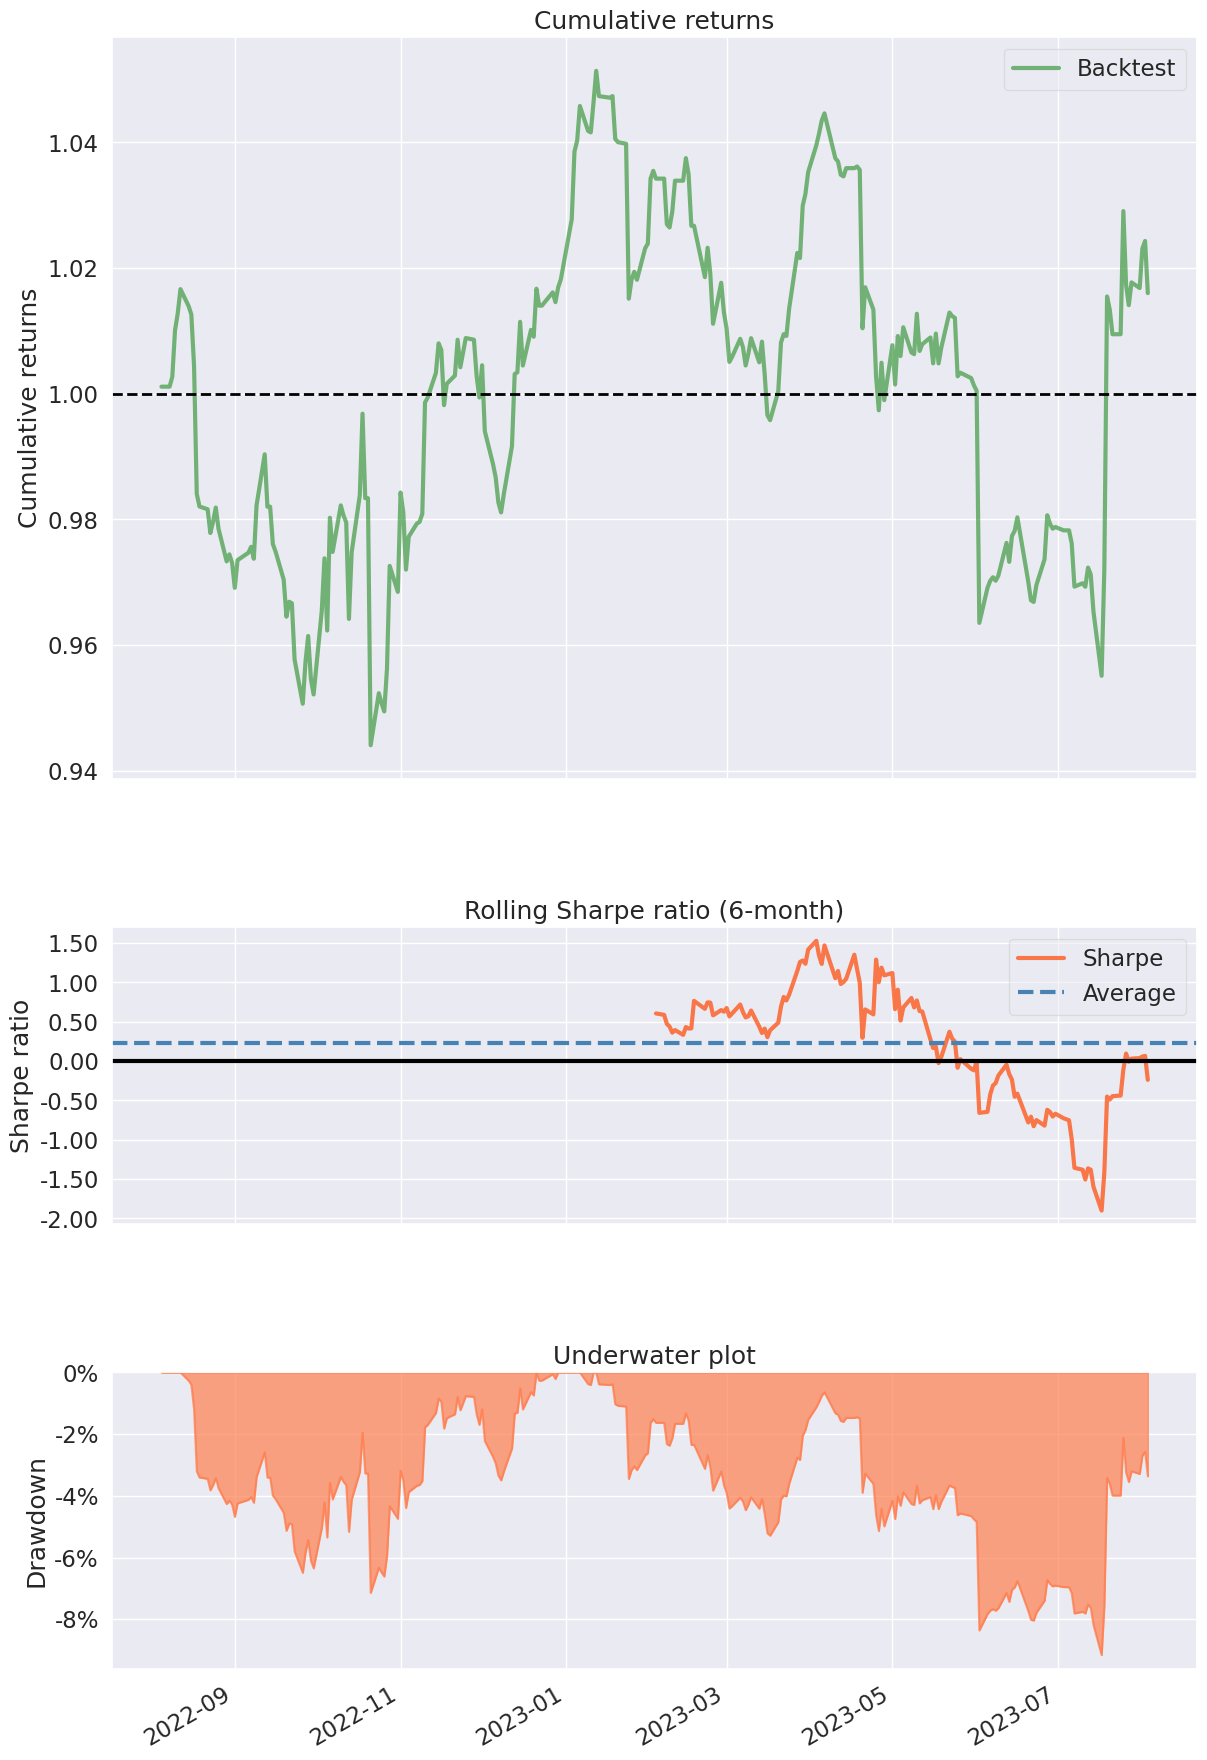

In [233]:
def main():

  bist_df = ShowTRMarket(BIST30)
  for ticker in bist_df['Ticker']:
    ShowTickerStats( ticker,"BIST")

  dow_df = ShowUSMarket(DOW30)
  for ticker in dow_df['Ticker']:
      ShowTickerStats( ticker,"US")

if __name__ == "__main__":
    main()